# Repetition code for up to 15 qubits

James R. Wootton, University of Basel

***
## 1 - Introduction


The aim of this study is to look at the properties of the repetion code when run using the 16 qubit *ibmqx3* device. A paper based on the results from this study can be found [here](https://arxiv.org/abs/1709.00990).

The repetition code is a classical error correcting code, with which a collection of noisy bits can be used to store a bit value with arbitrarily low noise.

The code can also be interpreted as a quantum error correcting code, in which the noisy bits are replaced by noisy qubits. Such a code can be used to store a *bit* with arbitrarily low noise. However, due to the limited set of errors that can be detected and corrected, it cannot fully protect a *qubit*.

Despite this fact, the repetition code based on qubits uses essentially the same resources and techniques as other quantum codes. It can therefore serve as a prelimary test of quantum error correction. An introduction to these concepts for a general audience can be found [here](http://decodoku.blogspot.ch/2016/01/what-is-error-correction-what-is.html).

Until now, the most extensive experiments of quantum repetition codes were implemented a few years ago by the team at Google/UCSB.

[J. Kelly et al., Nature **519**, *66–69* (2015)](https://www.nature.com/nature/journal/v519/n7541/full/nature14270.html)

The largest repetition code in this experiment used 5 qubits to store data (we call these *code qubits*), and an additional 4 *ancilla qubits* to mediate measurements. In this notebook we will use the 16 qubit device *ibmqx3* to implement codes of a variety of sizes, including some larger than those in the Google/UCSB experiment.

The number of code qubits in our experiments will be denoted *d*. The number of ancilla qubits in a repetition code is always *d-1*, one less than that of code qubits.

We will also use an additional qubit that is not part of the code, to compare storing a bit in a code with storing it in a single qubit. The total number of qubits needed is therefore *2d*. We will consider codes for *d=3...8*.

In each case we will do a single round of ancilla-assisted syndrome measurement followed by direct measurement of all qubits. This allows us to read out the value of the stored bit, as well as clues about errors that it may have suffered. Using this information, we can try to correct for the effects of the errors and recover the original value of the stored bit. By looking at how often this process succeeds, we will be able to see how well the system implements quantum error correction.

The conditions under which we will declare the system as able to successfully implement the repetion code will be those set out in,

[J. R. Wootton, A. Peter, J. R. Winkler, D. Loss, arXiv:1608.05053 (2016)](https://arxiv.org/abs/1608.05053).

In the program, the qubits in the register are labelled according to their address on the chip. The information can be found [here](https://github.com/IBM/qiskit-qx-info/tree/master/backends/ibmqx3).

    1---2---3---4---5   6---7---8
    |       |   |   |   |   |   |
    0--15--14--13--12--11--10---9

Lines in this diagram denote the possibility of a CNOT between the corresponding qubits.

Qubits in the repetition code alternate between code and ancilla qubits. The single qubit is placed at the end of the line. For the case of d=8, the layout of these qubits will be as follows.

    c2--a1--c1--a0--c0   s--c7--a6
     |       |   |   |   |   |   |
    a2--c3--a3--c4--a4--c5--a5--c6
 
The address of code qubit c$n$ therefore $(5-2n)$%$16$.

The address of ancilla qubit a$n$ is $(4-2n)$%$16$.

***

## 2 - Set Up

First we set up things required to run things using QISKit, and on the Quantum Experience.

Set up intructions can be found in the [IBM SDK](https://github.com/QISKit/qiskit-sdk-py/).

For more information about how to use the IBM Quantum experience, check out the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), and the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

The path (in the cell below) assumes that the folder holding this file is a subfolder of qiskit-tutorial/2_quantum_information.

In [1]:
import sys
sys.path.append("../../../qiskit-sdk-py/")
from qiskit import QuantumProgram
import Qconfig
# for visualization
from tools.visualization import plot_state

Next we import a few standard things.

In [2]:
import math, json, copy
import numpy as np

***
## 3 - Functions

The running of jobs and processing of data is handled by the following functions.

### *AddError*

Though our aim is to run on a real quantum device, a simulator can be used to make sure all is working as it should. There will be no errors in this case, so we will have to add in some fake ones.

This function checks whether a simulator is being used. If so, it adds a rotation around the x axis as a stand-in for errors.

The rotation chosen depends on the bit value stored in the code. The angle of rotation for stored *0* is half that for *1*. The reason is that realistic noise in the device has a bias towards transitions from *1* to *0*. Our choice of rotations serves as a simplistic way to obtain similar behaviour.

In [3]:
def AddError (script,q,num,simulator,bit):
    
    # errors are rotations around the x axis by a fraction of pi
    # this fraction is twice as large for qubits initially in state 1
    
    fracAncilla = 0.05
    
    fracCode = fracAncilla
    if (bit==1):
        fracCode = fracCode*2

    
    # if the code is simulated add these rotations for error like effects
    if (simulator):
        for address in range(0,num-1,2): # code qubits
            script.u3(fracCode * math.pi, 0.0, 0.0, q[address])
        for address in range(1,num-1,2): # ancilla qubits
            script.u3(fracAncilla * math.pi, 0.0, 0.0, q[address])
        script.u3(fracCode * math.pi, 0.0, 0.0, q[num-1]) # single qubit
                
        script.barrier()

### *AddCnot*

The input specifies control and target qubits for a CNOT gates.

The function implements the CNOT if it is allowed by the device used. If the CNOT is not directly possible, but one with control and target interchanged can be done, conjugation by Hadamards is performed. Otherwise it will print an error.

For a simulator, all things are possible.

In [4]:
def AddCnot(repetitionScript,q,control,target,simulator):
    
    # set the coupling map ()
    # b in coupling_map[a] means a CNOT with control qubit a and target qubit b can be implemented
    # note that is is not just copy and pasted from https://github.com/IBM/qiskit-qx-info/tree/master/backends/ibmqx3
    coupling_map = {0: [1], 1: [2], 2: [3], 3: [14], 4: [3, 5], 5: [], 6: [7, 11], 7: [10], 8: [7], 9: [10, 8], 10:[], 11: [10], 12: [5, 11, 13], 13: [4, 14], 14:[], 15: [0, 14]}
    
    # if such a CNOT is directly possible, we do it
    if ( target in coupling_map[control] or simulator):
        repetitionScript.cx(q[control], q[target])
    # if it can be done the other way round we conjugate with Hadamards
    elif ( control in coupling_map[target] ):
        repetitionScript.h(q[control])
        repetitionScript.h(q[target])
        repetitionScript.cx(q[target], q[control])
        repetitionScript.h(q[control])
        repetitionScript.h(q[target])
    else:
        print('Qubits ' + str(control) + ' and ' + str(target) + ' cannot be entangled.')

### *GetAddress*

Given a code qubit specified by input *codeQubit* this function gives the address of that qubit in the register. For the ancillas either side, use an offset of *+1* or *-1*.

For *codeQubit=0* only *offset=1* gives a valid ancilla. For *codeQubit=d-1* (the last one) *offset=-1* gives the last ancilla and *offset=1* gives the qubit that is trying to store the bit value on its own.

For a simulator we don't bother with the coupling graph, so things are different and simpler.

In [5]:
def GetAddress (codeQubit,offset,simulator):
    
    if (simulator):
        address = 2*codeQubit + offset
    else:
        address = (5-2*codeQubit-offset)%16
    
    return address

### *RunRepetition*

This function takes a specification for a repetition code, runs it and then returns the result.

Inputs:

* *bit* - Bit value to be stored in the repetition code. If it is not *1*, it will be treated as *0*.
    
* *d* - Number of code qubits

* *device* - The backend device on which the job will be run. This should be 'ibmqx3', 'local_qasm_simulator' or 'ibmqx_qasm_simulator'.

Output:

* *results* - Dictionary with bit strings as keys and the fraction of times that result occurred as values.

In [6]:
def RunRepetition(bit,d,device):
    
    # set the number of shots to use on the backend
    shots = 8192
    
    # determine whether a simulator is used
    simulator = (device!='ibmqx3')
    
    # if the simulator is used, we declare the minimum number of qubits required
    if (simulator):
        num = 2*d
    # for the real device there are always 16
    else:
        num = 16
        
    # now to set up the quantum program (QASM)
    Q_program = QuantumProgram()
    Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url
    # declare register of 5 qubits
    q = Q_program.create_quantum_register("q", num)
    # declare register of 5 classical bits to hold measurement results
    c = Q_program.create_classical_register("c", num)
    # create circuit
    repetitionScript = Q_program.create_circuit("repetitionScript", [q], [c])   
    
    
    # now we insert all the quantum gates to be applied
    # a barrier is inserted between each section of the code to prevent the complilation doing things we don't want it to
    
    # the stored bit is initialized by repeating it accross all code qubits same state
    # since qubits are automatically initialized as 0, we just need to do Xs if b=1
    if (bit==1):
        for codeQubit in range(d):
            repetitionScript.x( q[GetAddress(codeQubit,0,simulator)] )
        # also do it for the single qubit on the end for comparision
        repetitionScript.x( q[GetAddress(d-1,1,simulator)] )
       
    repetitionScript.barrier()
    
    # if the code is simulated add rotations for error like effects (and a barrier)
    AddError(repetitionScript,q,num,simulator,bit)
    
    # we then start the syndrome measurements by doing CNOTs between each code qubit and the next ancilla along the line
    for codeQubit in range(d-1):
        AddCnot(repetitionScript,q,GetAddress(codeQubit,0,simulator),GetAddress(codeQubit,1,simulator),simulator)
    repetitionScript.barrier()
    
    # if the code is simulated add rotations for error like effects (and a barrier)
    AddError(repetitionScript,q,num,simulator,bit)
    
    # next we perform CNOTs between each code qubit and the previous ancilla along the line
    for codeQubit in range(1,d):
        AddCnot(repetitionScript,q,GetAddress(codeQubit,0,simulator),GetAddress(codeQubit,-1,simulator),simulator)
    repetitionScript.barrier()
    
    # if the code is simulated add rotations for error like effects (and a barrier)
    AddError(repetitionScript,q,num,simulator,bit)
    
    # all qubits are then measured
    for address in range(num):
        repetitionScript.measure(q[address], c[address])
        
    # set the APIToken and API url
    Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])
    
    # run the job until actual results are given
    dataNeeded = True
    while dataNeeded:
            
        # compile and run the qasm
        executedJob = Q_program.execute(["repetitionScript"], backend=device, shots = shots, max_credits = 5, wait=5, timeout=600, silent=False)  
        # extract data
        results = executedJob.get_counts("repetitionScript")
        
        # see if it really is data
        if ('status' not in results.keys()):
            dataNeeded = False
        
    
    # the raw data states the number of runs for which each outcome occurred
    # we convert this to fractions before output.
    for key in results.keys():
        results[key] = results[key]/shots
    
    # return the results
    return results

### *AddProbToResults*

The inputs are a probability *prob* for a given bit string *string* that is to be added to a dictionary *results*. The probability is added to the previous value for that bit string if it exists.

In [7]:
def AddProbToResults(prob,string,results):
    
    if string not in results.keys():
        results[string] = 0
    
    results[string] += prob
    

### *CalculateError*

The job of this function is to determine the total probability that the decoding fails when the encoded bit value is that specified by the input *encodedBit*, given the look up table in *results*. The way in which this is done is depends on the decoding procedure, which we will now explain.

The decoder uses lookup tables, given by the input *results*. This is a pair of dictionaries, one for each possible value of the encoded bit, with bit strings as keys and probabilties of the form

$$result[encodedBit][string] = P(\,string\,|\,encodedBit\,)$$.

Suppose the decoder were to receive an output *string* from a single run of the code with unknown initial value. The goal is then to deduce the most likely value of the encoded bit. This can be done using

$$P(\,encodedBit\,|\,string\,) = \frac{P(\,string\,|\,encodedBit\,) \,\times\, P(\,encodedBit\,)}{P(\,string\,|\,0\,) + P(\,string\,|\,1)\,}.$$

Assuming $P(\,encodedBit\,)=0.5$, with no bias towards *0* or *1*, $P(\,encodedBit\,|\,string\,)$ is simply proportional to $P(\,string\,|\,encodedBit\,)$. We can therefore decode by simply looking at which lookup table has the highest value for *string*. The corresponding encoded bit value is taken to be *decodedBit*, the value that the decoder assumes it that of the encoded bit.

For example, consider a *d=3* code for which we only look at the output from the code qubits. Given a simple error model, we might expect results of the following form when *encodedBit=0*.

    result[0] = 
    {'000': 0.669, '001': 0.1, '010': 0.1, '100': 0.1, '110': 0.01, '101': 0.01, '011':0.01, '111':0.001}

Similarly for *encodedBit=1*

    result[1] = 
    {'000':0.001, '001': 0.01, '010': 0.01, '100':0.01, '110': 0.1, '101': 0.1, '011': 0.1, '111': 0.669}

Now suppose that at readout time, and with no idea what the encoded bit was, we find the result *'001'*. From the lookup tables we see that this result would occur with probability *0.1* for *encodedBit=0* and *0.01* for *encodedBit=1*. We should therefore take *decodedBit = 0*.

Note that we have not taken the usual step of ignoring the logical readout, and focussing only on the abstract syndrome. Though it usually makes things simpler, it would just make things harder in this case.

Note also that the lookup tables are populated by experimental data, and so decoding will suffer from numerical innacuracies when the sample size is too small.


In [8]:
def CalculateError (encodedBit,results):
    
    # total prob of error will be caculated by looping over all strings
    # we initialize the value to 0
    error = 0
    
    # all strings that have results for the given encoded bit are looped over
    for string in results[encodedBit].keys():

        # the probability P(string|encodedBit) is extracted
        right = results[encodedBit][string]
        
        # as is the probability P(string|!encodedBit)
        # if there is no result for this value in the table, the prob is 0
        wrong = 0
        if string in results[(encodedBit+1)%2].keys():
            wrong = results[(encodedBit+1)%2][string]

        # if this is a string for which P(string|!encodedBit)>P(string|encodedBit), the decoding fails
        # the probabilty P(string|encodedBit) is then added to the error
        if (wrong>right):
            error += right
        # if P(string|!encodedBit)=P(string|encodedBit), the decoder randomly chooses between them
        # P(failure|string) is therefore 0.5 in this case
        elif (wrong==right):
            error += 0.5*right
        # otherwise the decoding succeeds, and we don't care about that
            
    return error

### *GetData*

For a given backend *device*, this function runs the repetition code for both possible values of the encoded bit for *totalRuns* samples with code distance from 3 to *maxSize*. The full data is then saved to file, with the file name reflecting the code distance, run and encoded bit.

In [9]:
def GetData(device,maxSize,totalRuns):
    
    # loop over code sizes that will fit on the chip (d=3 to d=8)
    for d in range(3,maxSize+1):

        print("**d = " + str(d) + "**")
    
        # do the runs
        for run in range(totalRuns):

            print("**Run " + str(run) + "**")

            # get data for each encoded bit value
            for bit in range(2):

                # run the job and put results in resultsRaw
                resultsRaw = RunRepetition(bit,d,device)

                f = open('Repetition_Code_Results/'+device+'/results_d=' + str(d) + '_run=' + str(run) + '_bit=' + str(bit) + '.txt', 'w')
                f.write( str(resultsRaw) )
                f.close()

### *ProcessData*

For a given data set specified by *maxSize* and *totalRuns*, and an encoded bit value *encodedBit*, various probabilties are calculated.

The first output contains error probabilities for codes. This is arranged as follows.

* *codeResults[d-3]* gives the results for a code of distance *d*
* *codeResults[d-3][0]* gives results for the whole code of distance *d*
* *codeResults[d-3][k]* gives results for the effective distance *d-k* code obtained by ignoring the last *k* code qubits and ancillas
* *codeResults[d-3][k][0]* is the error prob when decoding uses both code and ancilla qubits
* *codeResults[d-3][k][1]* is the variance for the above
* *codeResults[d-3][k][2]* is the error prob when decoding uses only code qubits
* *codeResults[d-3][k][3]* is the variance for the above

The second contains probabilities that single qubits across the code have value 1. This is arranged as follows.

* *singleResults[d-3][j][0]* is the probability of state *1* for qubit *j* when used in a code of distance *d*
* *singleResults[d-3][j][1]* is the variance for the above

Here *j* reflects placement in the code. Qubit *c0* is *j=0*, *a0* is j=1*, etc.

The third output is a collection of dictionaries *combinedResultsCode[d-3]*, one for each code distance and stored bit value. Each dictionary contains the results from the device for that case, combined over all runs. It is also truncated to show only results for bits that were code qubits. Note that the results returned are for both encoded bits, so the *encodedBit* input for the function is not used here.

In [10]:
def ProcessData(device,encodedBit,maxSize,totalRuns):
    
    # determine whether a simulator is used
    simulator = (device!='ibmqx3')
    
    
    # initialize list used to store the calculated means and variances for results from the codes
    codeResults = [[[0]*4 for _ in range(j)] for j in range(3,maxSize+1)]
    singleResults = [[[0]*2 for _ in range(16)] for _ in range(3,maxSize+1)]
    # singleResults[d-3][j][0] is the probability of state 1 for qubit j when used in a code of distance d
    # singleResults[d-3][j][1] is the variance for the above
    
    
    # the results will show that the case of partial decoding requires more analysis
    # for this reason we will also output combinedCodeResults, which is all runs of codeResults combined
    # here we initialize list of combined results from the code only case
    combinedResultsCode = [[{} for _ in range(3,maxSize+1) ] for _ in range(2)]
    
    
    # loop over code sizes...
    for d in range(3,maxSize+1):    
        # ...and the runs
        for run in range(0,totalRuns):
            
            # we are going to fill a bunch of dictionaries with results
            # each has two copies, one for each possible encoded bit

            # the results that come fresh from the backend
            resultsVeryRaw = [{} for _ in range(2)]
            resultsRaw = [{} for _ in range(2)]
            # the results from the full code (including ancillas)
            # resultsFull[k] gives results for the effective distance d-k code obtained by ignoring the last k code qubits and ancillas
            resultsFull = [[{} for _ in range(d)] for _ in range(2)]
            # the same but with ancilla results excluded
            resultsCode =  [[{} for _ in range(d)] for _ in range(2)]
            # results each single bit
            resultsSingle = [[{} for _ in range(16)] for _ in range(2)]

            # we get results for both possible encoded bits
            for bit in range(2):

                # get results from file
                f = open('Repetition_Code_Results/'+device+'/results_d=' + str(d) + '_run=' + str(run) + '_bit=' + str(bit) + '.txt')
                resultsVeryRaw[bit] = eval(f.read())
                f.close()
                
                # loop over all keys in the raw results and look at the ones without strings as values
                # since all such entries should have a bit string as a key, we call it stringVeryRaw
                for stringVeryRaw in resultsVeryRaw[bit].keys():
                    if resultsVeryRaw[bit][stringVeryRaw] is not str:
                        
                        # create a new dictionary in which each key is padded to a bit string of length 16
                        stringRaw = stringVeryRaw.rjust(16,'0')
                        resultsRaw[bit][stringRaw] = resultsVeryRaw[bit][stringVeryRaw]


                # now stringRaw only has data in the correct format
                # let's loop over its entries and process stuff
                for stringRaw in resultsRaw[bit].keys():

                    # get the prob corresponding to this string
                    probToAdd = resultsRaw[bit][stringRaw]

                    # first we deal with resultsFull and resultsCode

                    # loop over all truncated codes relevant for this d
                    for k in range(d):
                        # distance of this truncated code
                        dd = d-k

                        # extract the bit string relevant for resultsFull
                        # from left to right this will alternate between code and ancilla qubits in increasing order
                        stringFull = ''
                        for codeQubit in range(dd): # add bit value for a code qubit...
                            stringFull += stringRaw[15-GetAddress(codeQubit,0,simulator)]
                            if (codeQubit!=(d-1)): #...and then the ancilla next to it (if we haven't reached the end of the code)
                                stringFull += stringRaw[15-GetAddress(codeQubit,1,simulator)]

                        # remove ancilla bits from this to get the string for resultsCode
                        stringCode = ""
                        for n in range(dd):
                            stringCode += stringFull[2*n]

                        AddProbToResults(probToAdd,stringFull,resultsFull[bit][k])
                        AddProbToResults(probToAdd,stringCode,resultsCode[bit][k])

                    # now we'll do results single

                    # the qubits are listed in the order they are in the code
                    # so for each code qubit
                    for jj in range(8):
                        # loop over it and its neighbour
                        for offset in range(2):
                            stringSingle = stringRaw[15-GetAddress(jj,offset,simulator)]
                            AddProbToResults(probToAdd,stringSingle,resultsSingle[bit][2*jj+offset])

                # combined this run's resultsCode with the total, using the k=0 values
                for stringCode in resultsCode[bit][0].keys():
                    probToAdd = resultsCode[bit][0][stringCode]/10
                    AddProbToResults(probToAdd,stringCode,combinedResultsCode[bit][d-3])
        

            # initialize list used to store the calculated means and variances for results from the codes
            codeSample = [[0]*2 for _ in range(d)]
            # here
            # codeSample gives the results
            # codeSample[0] gives results for the whole code
            # codeSample[k] gives results for the effective distance d-k code obtained by ignoring the last k code qubits and ancillas
            # codeSample[k][0] is the error prob when decoding uses both code and ancilla qubits
            # codeSample[k][1] is the error prob when decoding uses only code qubits
            singleSample = [0]*16
            # singleSample[j] is the probability of state 1 for qubit j when the required bit value is encoded

            # write results in            
            for k in range(d):
                codeSample[k][0] = CalculateError(encodedBit,[resultsFull[0][k],resultsFull[1][k]])
                codeSample[k][1] = CalculateError(encodedBit,[resultsCode[0][k],resultsCode[1][k]])
            for j in range(16):
                if '1' in resultsSingle[encodedBit][j].keys():
                    singleSample[j] = resultsSingle[encodedBit][j]['1']
            
            
            # add results from this run to the overall means and variances
            for k in range(d):
                for l in range(2):
                    codeResults[d-3][k][2*l] += codeSample[k][l] / totalRuns # means
                    codeResults[d-3][k][2*l+1] += codeSample[k][l]**2 / totalRuns # variances
            for j in range(16):
                singleResults[d-3][j][0] += singleSample[j] / totalRuns
                singleResults[d-3][j][1] += singleSample[j]**2 / totalRuns

        # finish the variances by subtracting the square of the mean
        for k in range(d):
            for l in range(1,4,2):
                codeResults[d-3][k][l] -= codeResults[d-3][k][l-1]**2
        for j in range(16):
                singleResults[d-3][j][1] -= singleResults[d-3][j][0]**2

    
    # return processed results                                                                                                                        
    return codeResults, singleResults, combinedResultsCode

### *MakeGraph*

Plots the sets of data in *Y* with error bars given by the corresponding variances in *y*. Values for the X axis are in *X*. Labels for x axis and y axis are in *axisLabel*. Labels for the legend can be supplied in *labels*, though there is no legend by default. The position can be supplied in *legendPos*. It is upper right be default. The numbers can be printed to screen using *verbose=True* and the graph can be made logarithmic on the y axis using *log=True*. Both these are off by default.

In [11]:
# first a quick function to do logs in a nice way
def Log (x):
    if (x>0):
        y = math.log( x , 10 )
    else:
        y = math.nan # the input would cause a domain error, we output a nan    
    return y

In [12]:
def MakeGraph(X,Y,y,axisLabel,labels=[],legendPos='upper right',verbose=False,log=False):
    
    from matplotlib import pyplot as plt
    plt.rcParams.update({'font.size': 30})
    
    # if verbose, print the numbers to screen
    if verbose==True:
        print("\nX values")
        print(X)
        for j in range(len(Y)):
            print("\nY values for series "+str(j))
            print(Y[j])
            print("\nError bars")
            print(y[j])
            print("")
    
    # convert the variances of varY into widths of error bars
    for j in range(len(y)):
        for k in range(len(y[j])):
            y[j][k] = math.sqrt(y[j][k]/2)
            if log==True:
                yp = Log(Y[j][k]+y[j][k]) - Log(Y[j][k])
                if (Y[j][k]-y[j][k]>0):
                    ym = Log(Y[j][k]) - Log(Y[j][k]-y[j][k])
                else:
                    ym = 0
                y[j][k] = max(yp,ym)
    
    # if a log plot, do the logs
    if log==True:
        for j in range(len(Y)):
            for k in range(len(Y[j])):
                Y[j][k] = Log(Y[j][k])
    
    
    plt.figure(figsize=(20,10))
    
    
    # add in the series
    for j in range(len(Y)):
        if labels==[]:
            plt.errorbar(X, Y[j], marker = "x", markersize=20, yerr = y[j], linewidth=5)
        else:
            plt.errorbar(X, Y[j], label=labels[j], marker = "x", markersize=20, yerr = y[j], linewidth=5)
    
    plt.legend(loc=legendPos)
    
    # label the axes
    plt.xlabel(axisLabel[0])
    plt.ylabel(axisLabel[1])
    
    # make sure X axis is fully labelled
    plt.xticks(X)

    # make the graph
    plt.show()
    
    plt.rcParams.update(plt.rcParamsDefault)
    

***
## 4 - Results


We will see how well the repetition code works for *d* from *3* to *8*.

For each code of distance *d*, the probability for a logical error is calculated given each possible bit value that can be encoded. This is done for the case of **full decoding**, in which the full results of the code are used (from both code qubits and ancilla qubits) and for **partial decoding** in which the ancilla results are ignored and only the results of the code qubits are used.

The same is also done for truncated codes of distance *dd=d-k*. For example, consider the *d=5* code

    c0--a0--c1--a1--c2--a2--c3--a3--c4
    
If the results of *a3* and *c4* were ignored, the decoding would effectively be the same as that of the *d=3* code

    c0--a0--c1--a1--c2--a2--c3
    
The difference between this truncated code and the true *d=3* code is that the former has additional noise coming from the additional CNOTs of the *d=5* code. Considering these truncated code gives us another perspective on how error suppression changes as code distance is increased.

The probability of a qubit being in state *1* is also determined for every qubit on the code at the end of the circuit. This will give us an idea of how well qubits are holding to their encoded values. The qubit located next to the code is used for a single qubit encoding. The results for this will therefore allow us to see how well a many qubit encoding compares against a single qubit one.

For successfully working repetition codes, we would expect results to show the following for each *d*.

1) The logical error probability for the code the after full decoding should be significantly less than that for the single qubit encoding.

2) It must also be significantly greater than that for after partial decoding.

3) Each code should have lower logical error probabilities (for full and partial decoding) than the truncated codes derived from them.

Condition (1) ensures that using a code actually provides better protection against errors than just using a single qubit for each bit. Condition (2) ensures that the ancilla assisted measurements actually provide useful information for the decoding. If they did not, the entangling gates would essentially just be another source of noise, rather than a useful quantum operation.

When running the following, you will be asked if you want to look at the real device or a simulator. You'll then be asked if you have pre-existing data. If not, new data will be generated.

Note that the numerical data can be printed for the following plots by adding *verbose=True* to the corresponding call to *MakeGraph*. The plots can be given a logarithmic y axis using *log=True*.

In [13]:
# set device to use
# this also sets the maximum d. We only go up to 6 on the simulator
userInput = input("Do you want results for the real device? (input Y or N) If not, results will be from a simulator. \n").upper()
if (userInput=="Y"):
    device = 'ibmqx3'
    maxSize = 8
else:
    device = 'local_qasm_simulator'
    maxSize = 6


# determine whether data needs to be taken
userInput = input("Do you want to process saved data? (Y/N) If not, new data will be obtained. \n").upper()
if (userInput=="Y"):
    dataAlready = True
else:
    dataAlready = False

# set number of runs used for stats
totalRuns = 10 # should be 10

# if we need data, we get it
if (dataAlready==False):

    # get the required data for the desired number of runs
    GetData(device,maxSize,totalRuns)

Do you want results for the real device? (input Y or N) If not, results will be from a simulator. 
y
Do you want to process saved data? (Y/N) If not, new data will be obtained. 
y


In [14]:
codeResults = [[],[]]
singleResults = [[],[]]
for encodedBit in range(2):
    codeResults[encodedBit], singleResults[encodedBit], combinedResultsCode = ProcessData(device,encodedBit,maxSize,totalRuns)

The following six plots are for codes of distance *d=3* to *d=8*. Each has two series, one for an encoded *0* and one for an encoded *1*. The plots show the probability that each qubit in the chip is measured to be in state *1* at the end of the process.

In the ideal case, we would expect this probability to be zero in all cases for an encoded *0*. For an encoded *1*, it should be zero for all ancilla and unused qubits, and one for the code qubits. It should also be one for the single qubit used to encode a logical qubit.



***Final state of each qubit for code of distance d = 3***


/home/james/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


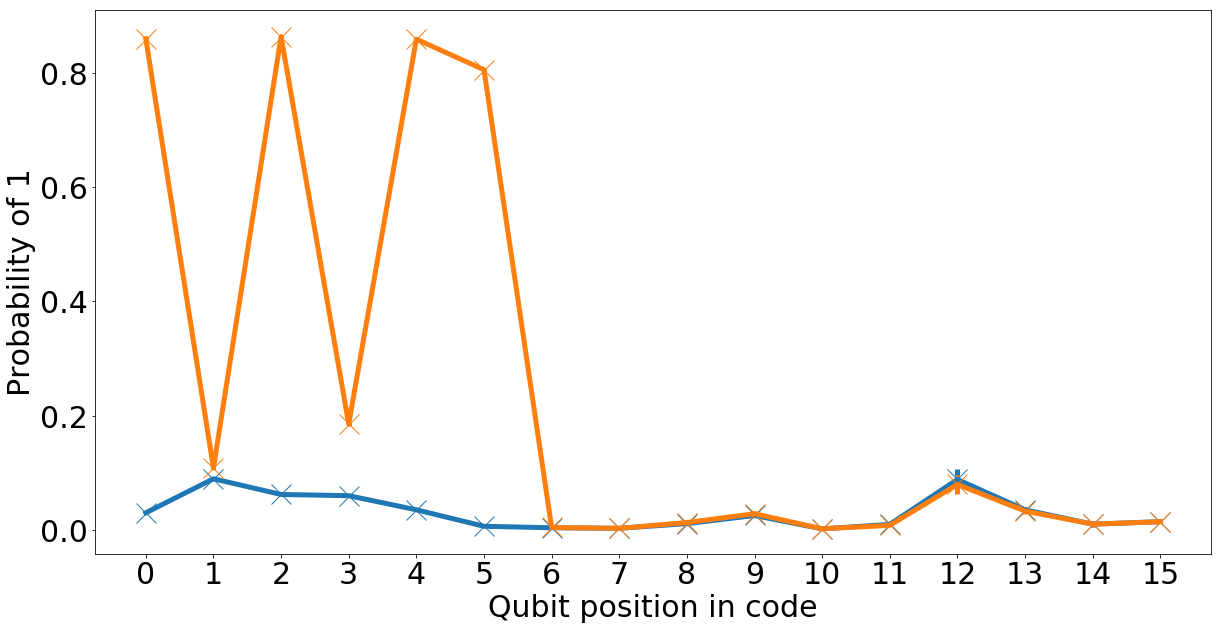



***Final state of each qubit for code of distance d = 4***


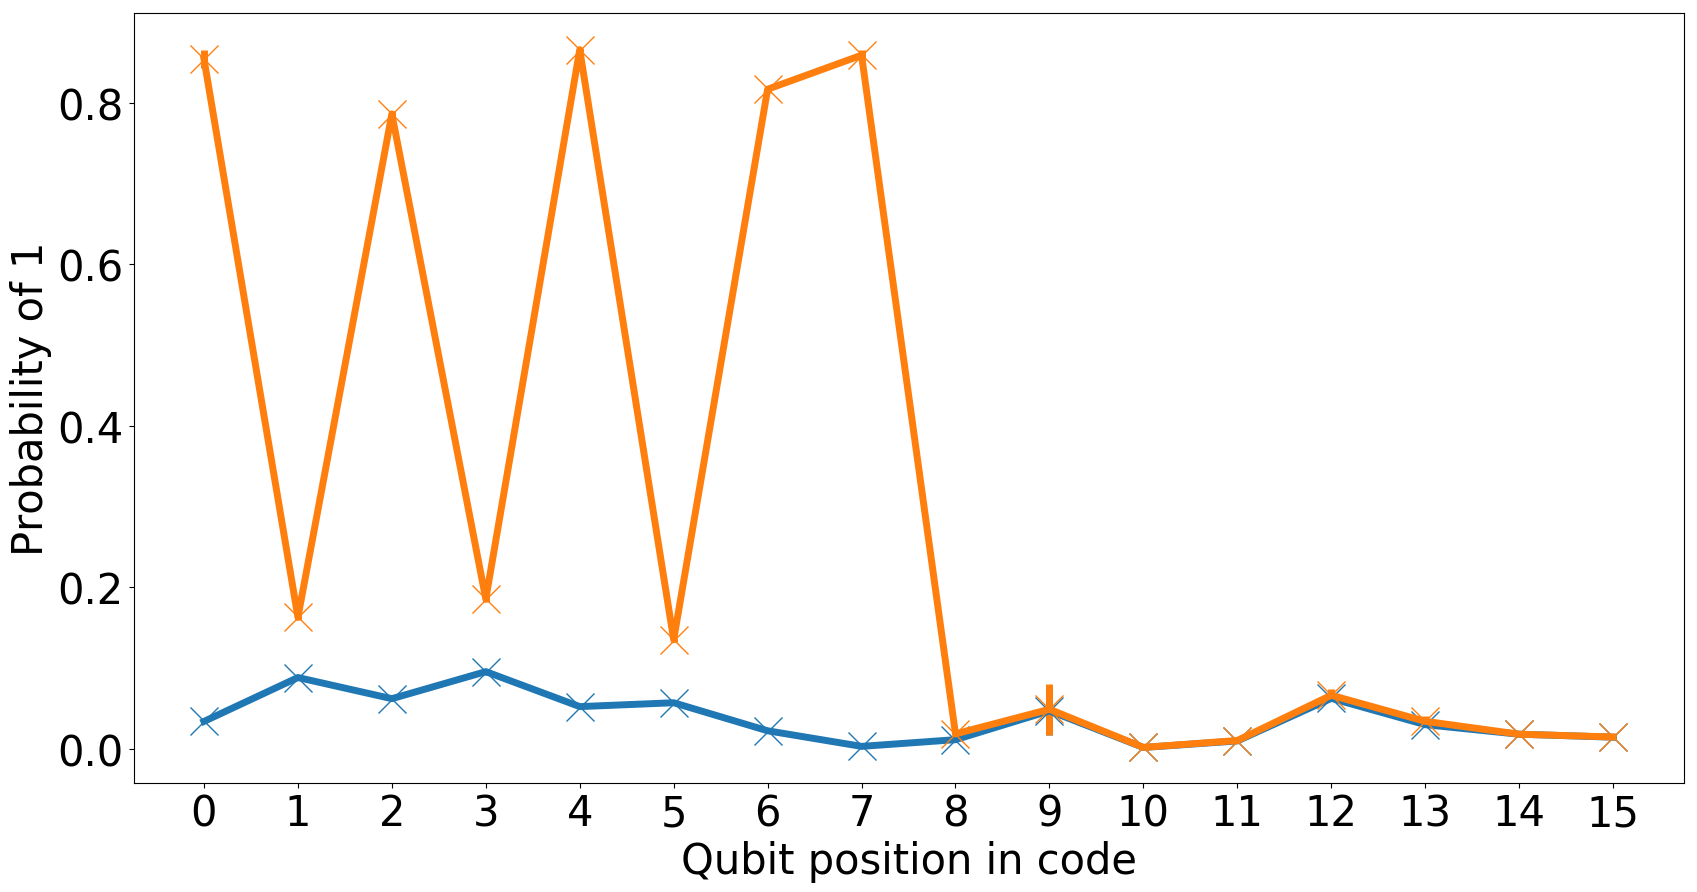



***Final state of each qubit for code of distance d = 5***


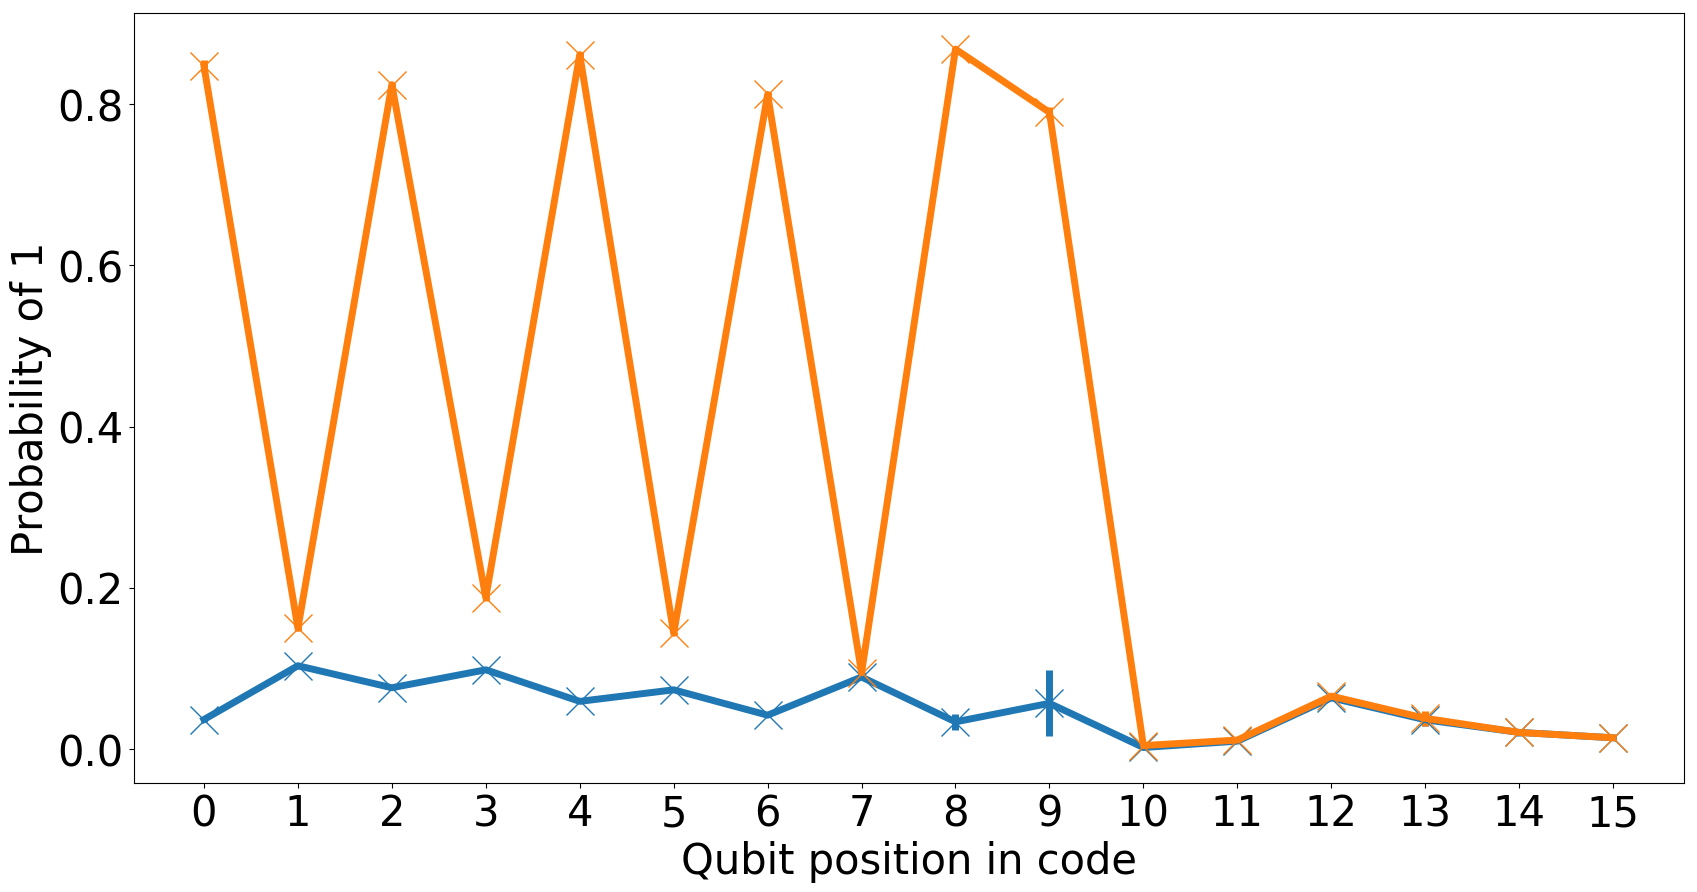



***Final state of each qubit for code of distance d = 6***


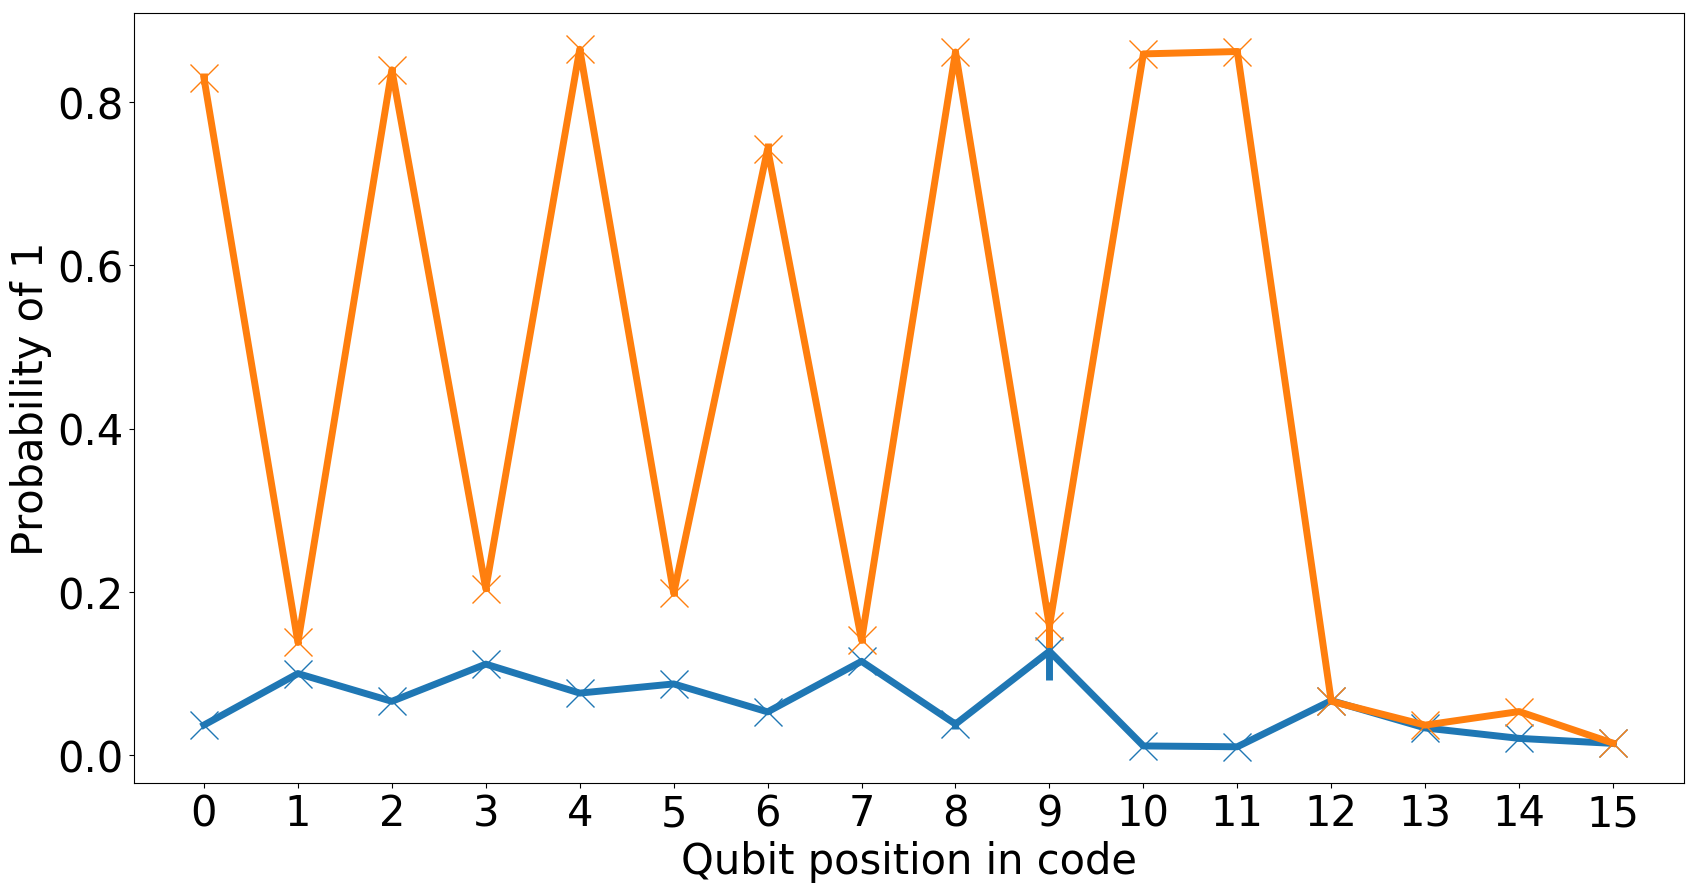



***Final state of each qubit for code of distance d = 7***


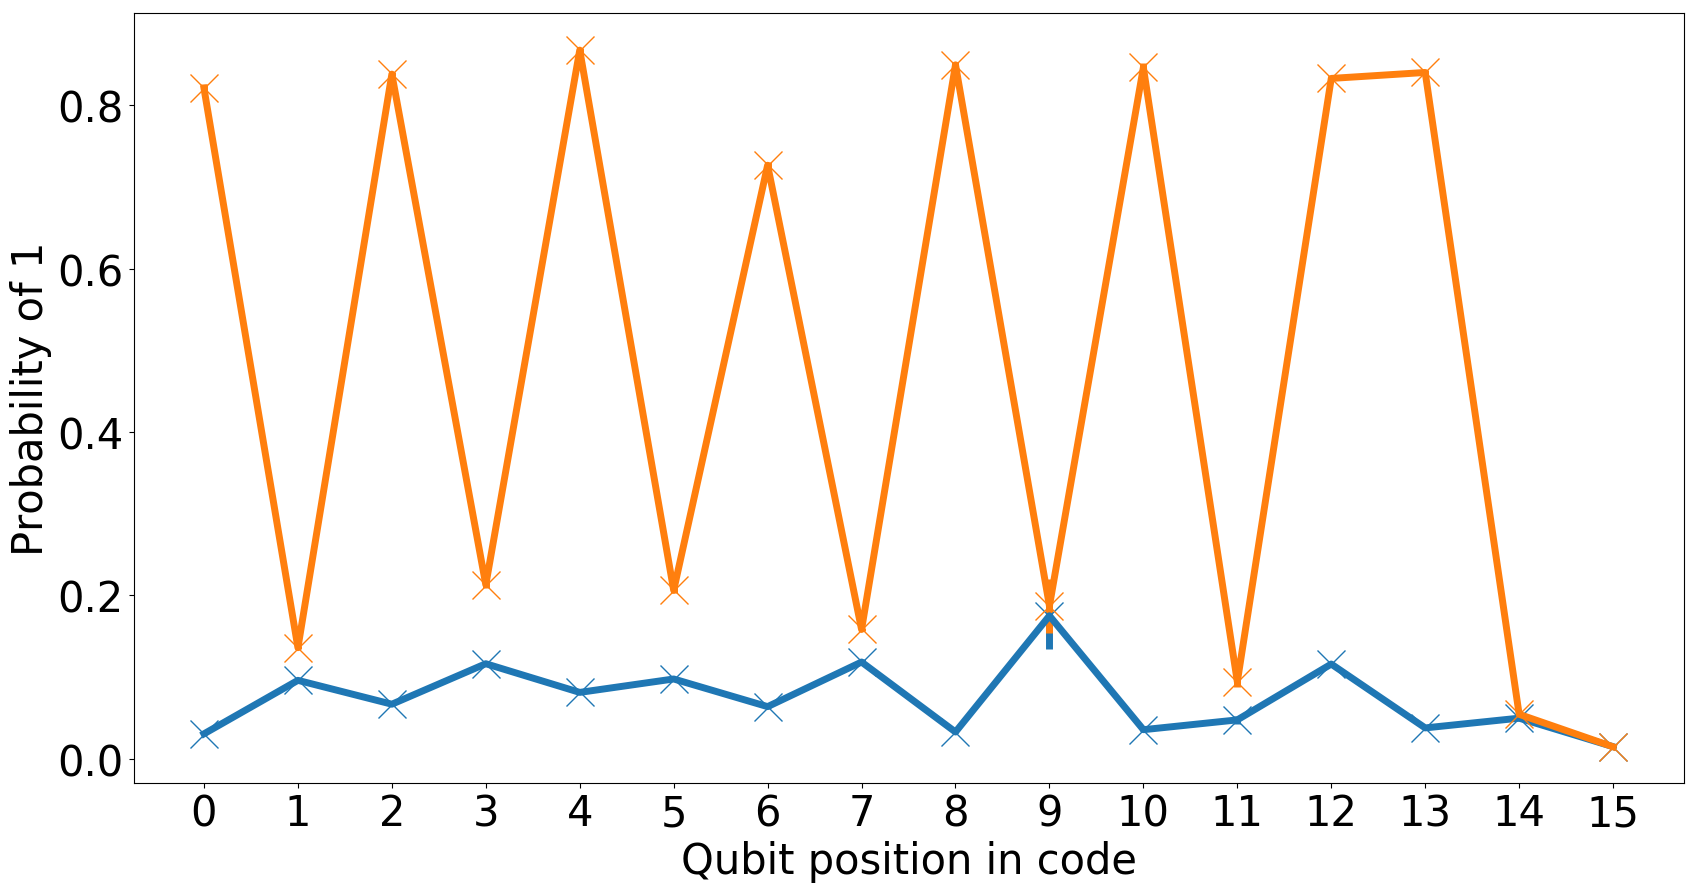



***Final state of each qubit for code of distance d = 8***


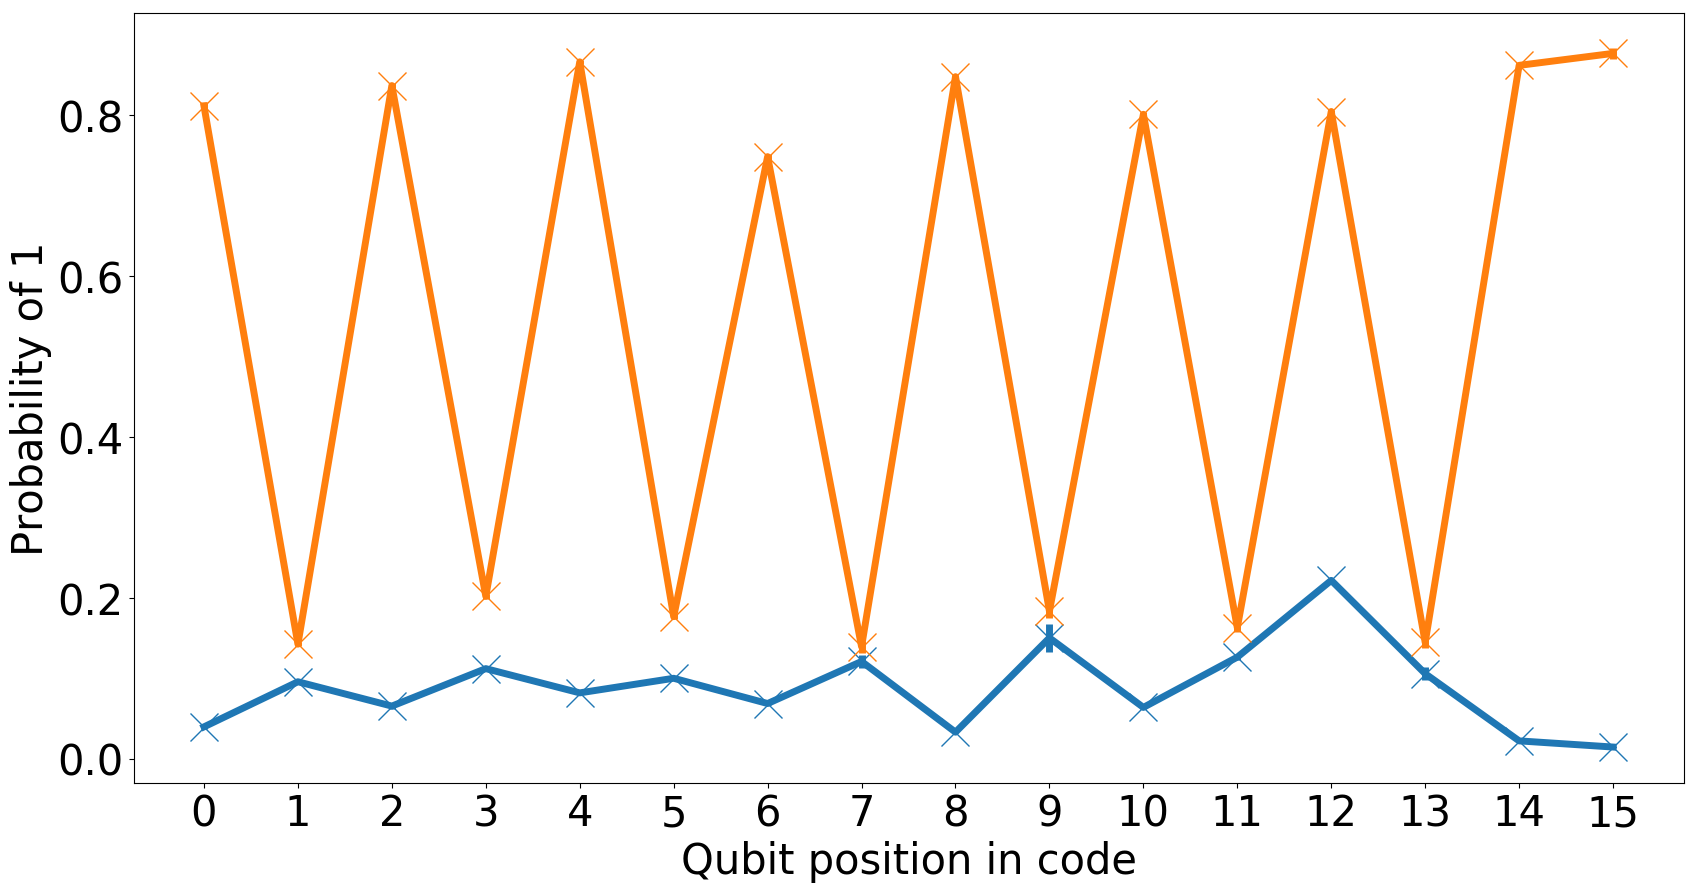

In [15]:
# plot for single qubit data for each code distance
for d in range(3,maxSize+1):
    X = range(16)
    Y = []
    y = []
    # a series for each encoded bit
    for encodedBit in range(2):        
        Y.append([singleResults[encodedBit][d-3][j][0] for j in range(16)])
        y.append([singleResults[encodedBit][d-3][j][1] for j in range(16)])
    # make graph
    print("\n\n***Final state of each qubit for code of distance d = " + str(d) + "***")
    MakeGraph(X,Y,y,['Qubit position in code','Probability of 1'])

The following four graphs show logical error probability plotted against effective code distance. The cases they consider are (in order):

* Stored 0, full decoding;
* Stored 0, partial decoding;
* Stored 1, full decoding;
* Stored 1, partial decoding.

The six series in each represent data from codes of different sizes. The rightmost data point for each is the logical error probability when the full code is used, and so the effective code distance is *d*. The point for effective code distance *d-1* is calculated from the same data, but with the final code and ancilla qubits ignored to effectively lower the code distance. The rest of the points are obtained by repeating this process.

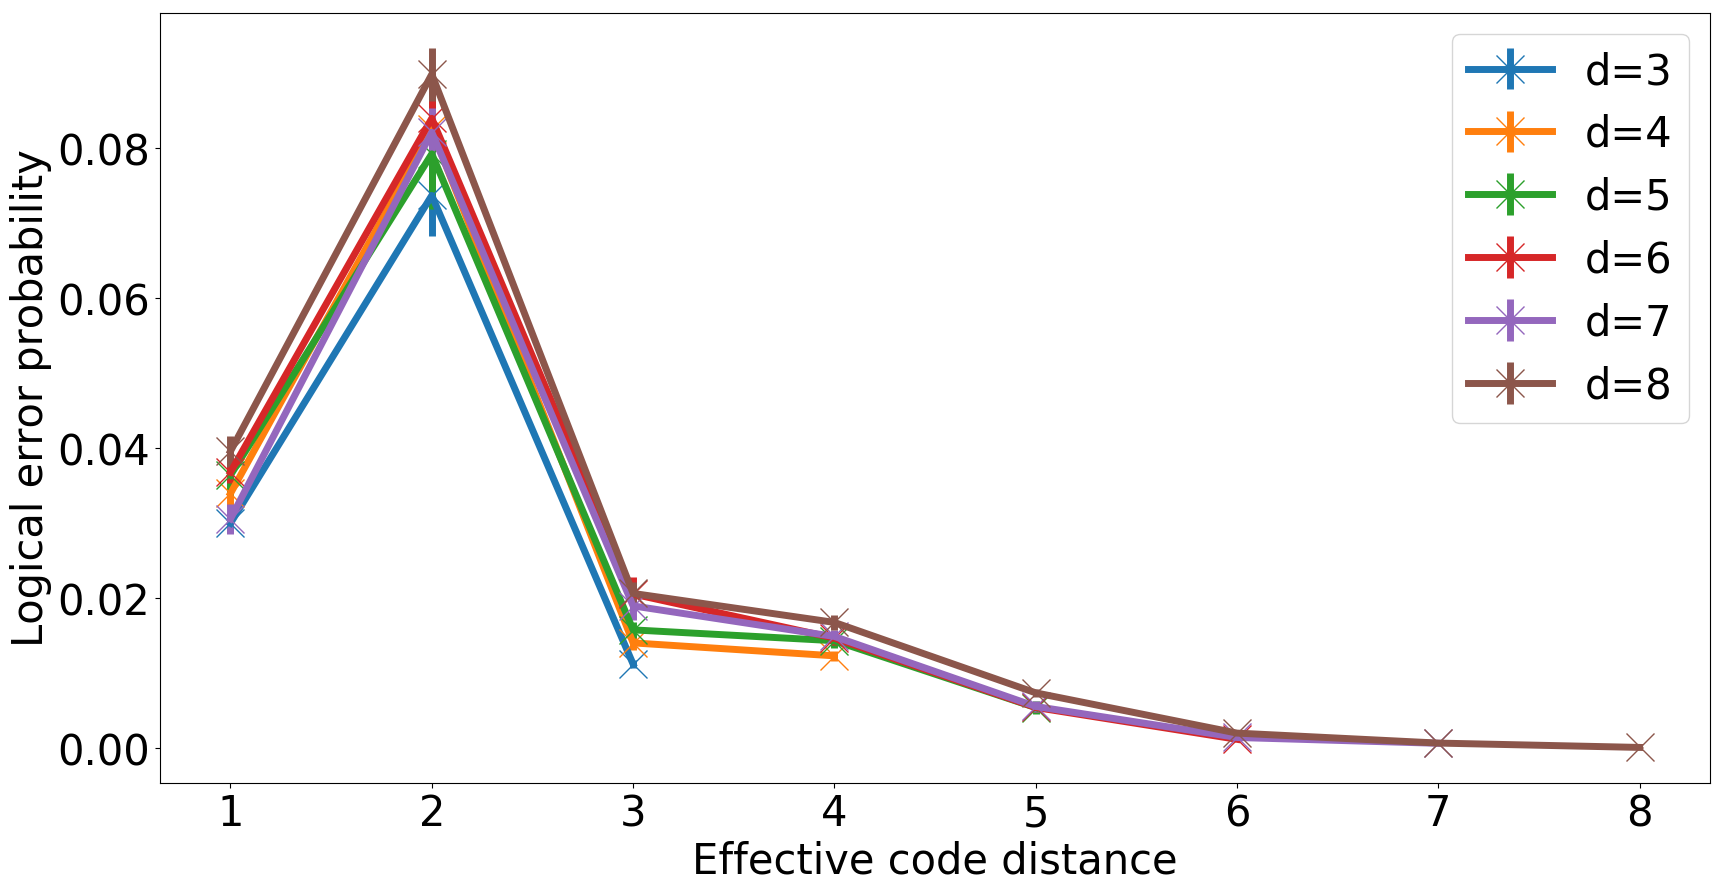

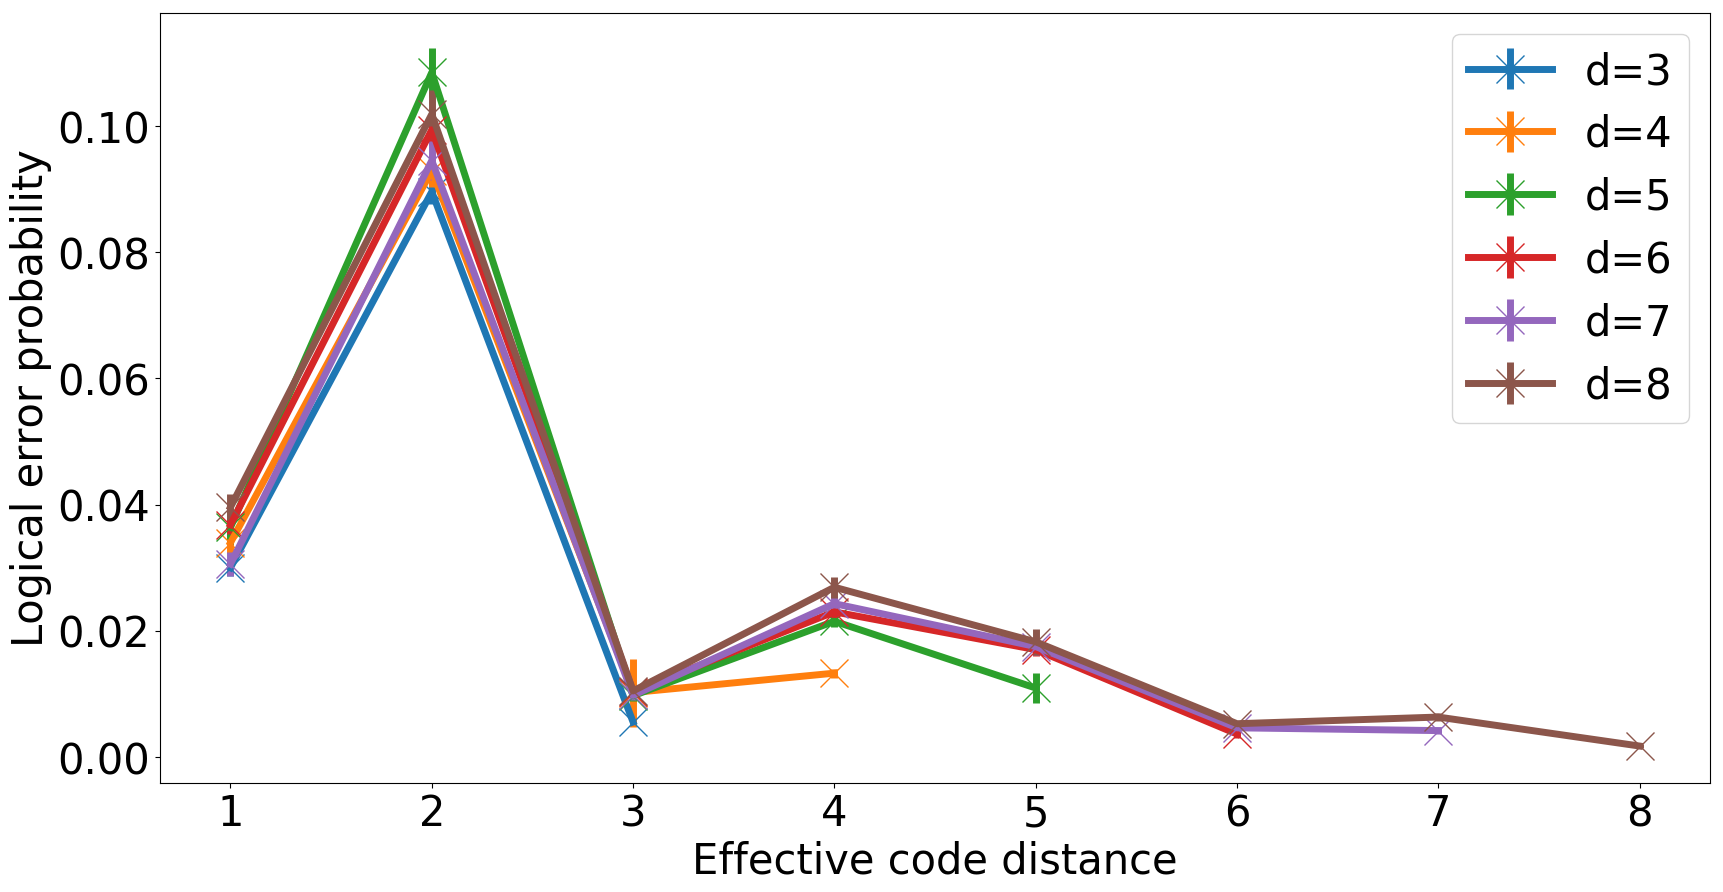

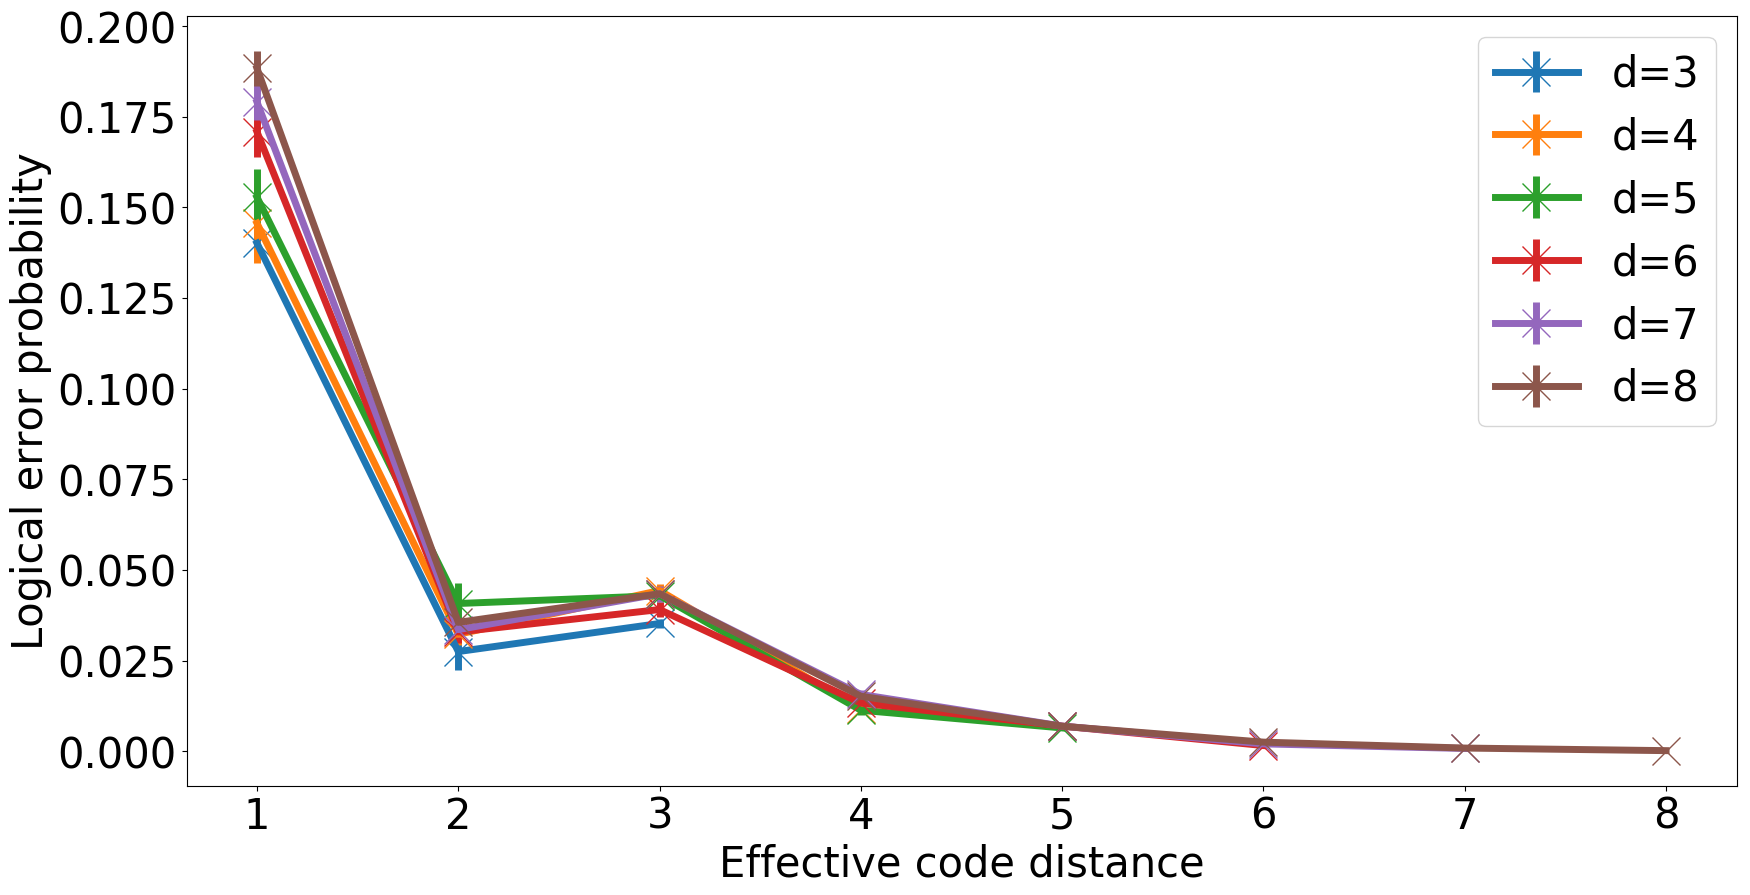

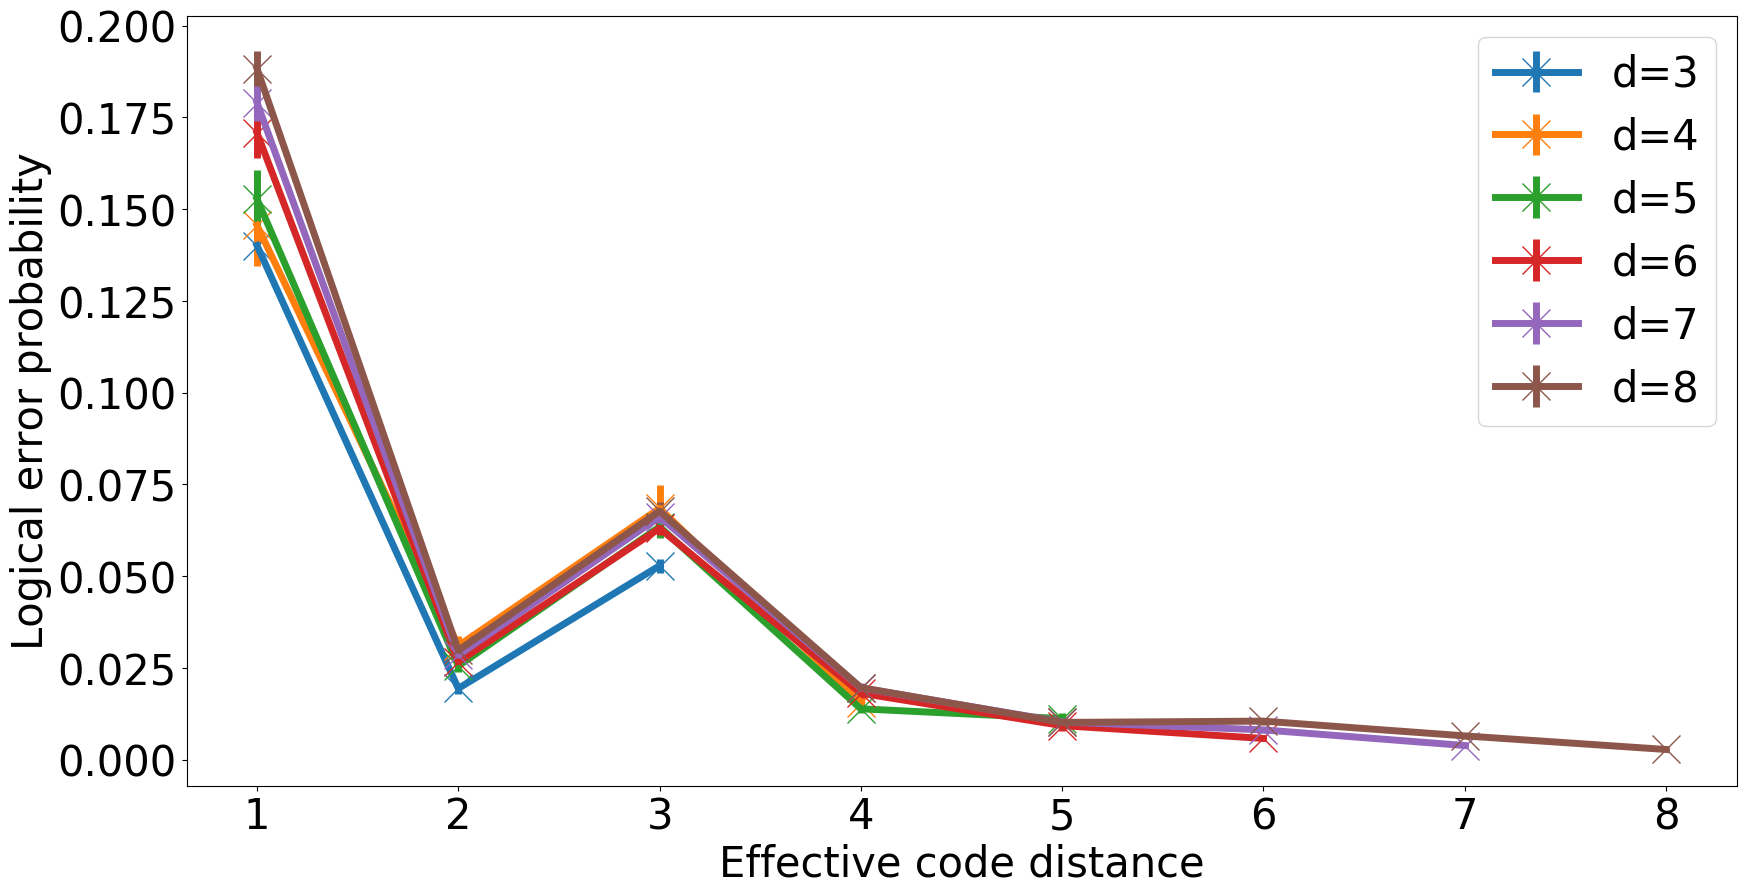

In [16]:
for encodedBit in range(2): # separate plots for each encoded bit
    for decoding in ['full','partial']:
        dec = (decoding=='partial') # this is treated as 0 if full and 1 if partial
        X = range(1,maxSize+1)
        Y = []
        y = []
        for d in range(3,maxSize+1):# series for each code size
            seriesY = [math.nan]*(maxSize)
            seriesy = [math.nan]*(maxSize)
            for k in range(d):
                seriesY[d-k-1] = codeResults[encodedBit][d-3][k][2*dec+0]
                seriesy[d-k-1] = codeResults[encodedBit][d-3][k][2*dec+1]
            Y.append(seriesY)
            y.append(seriesy)
        labels = ['d=3','d=4','d=5','d=6','d=7','d=8']
        MakeGraph(X,Y,y,['Effective code distance','Logical error probability'],
                  labels=labels,legendPos = 'upper right')   

The following two plots are for an encoded logical *0* and logical *1*, respectively. They show the probability of a logical error for (non-truncated) codes of various sizes. The two series in each represent full decoding (using both code and ancilla qubits) and partial decoding (using only code qubits).

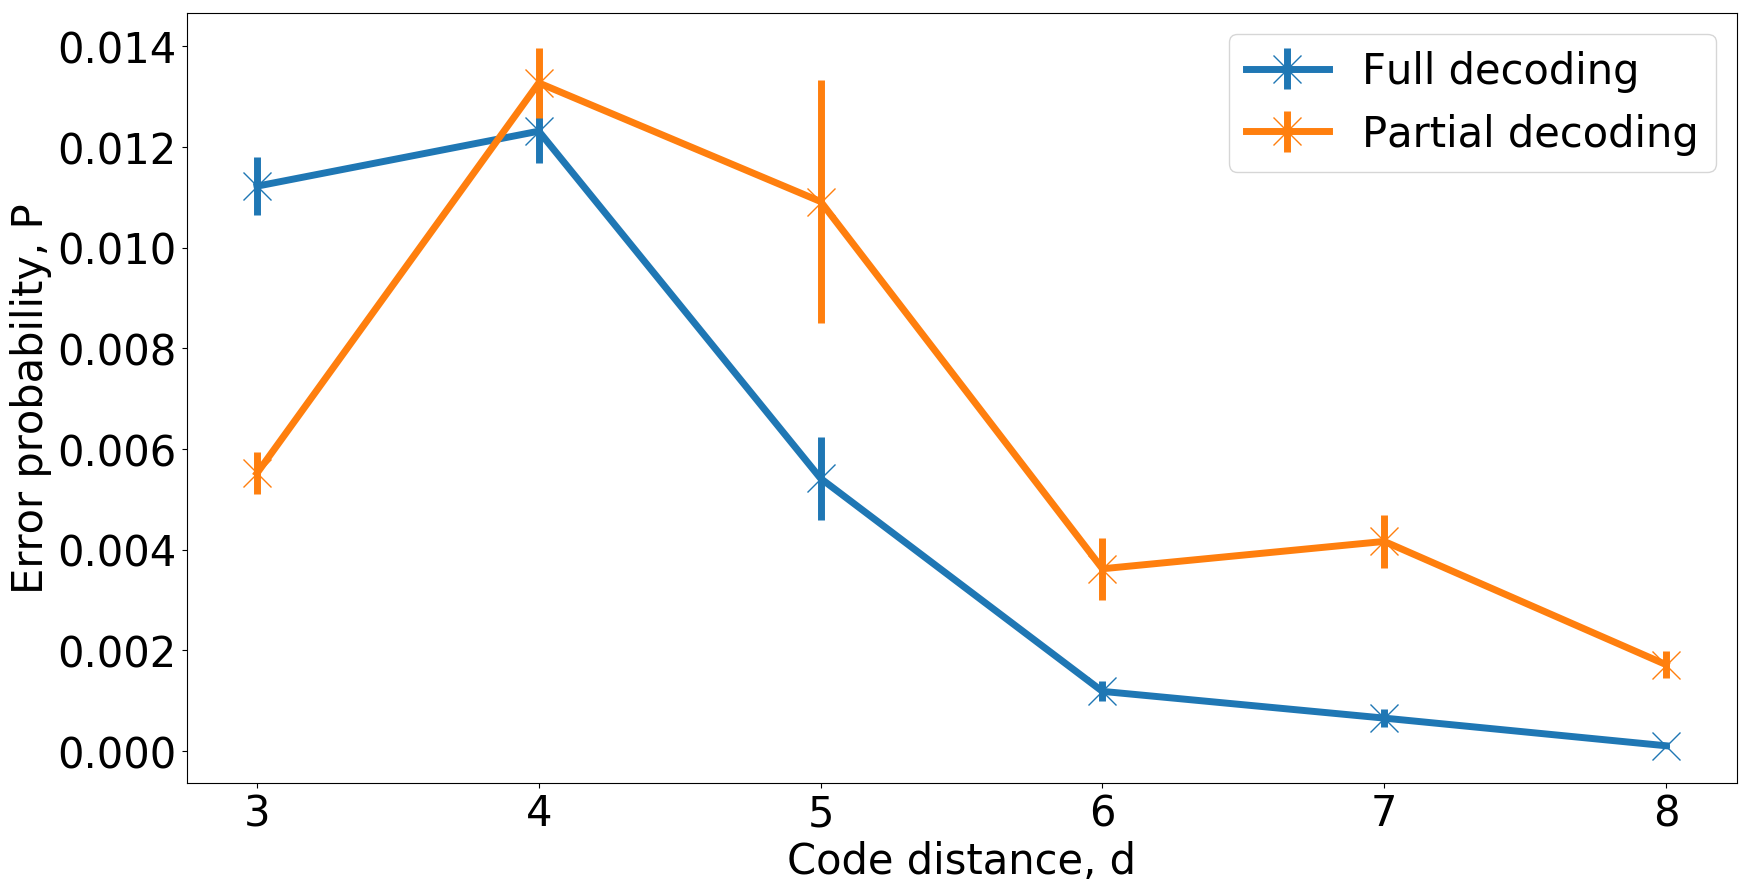

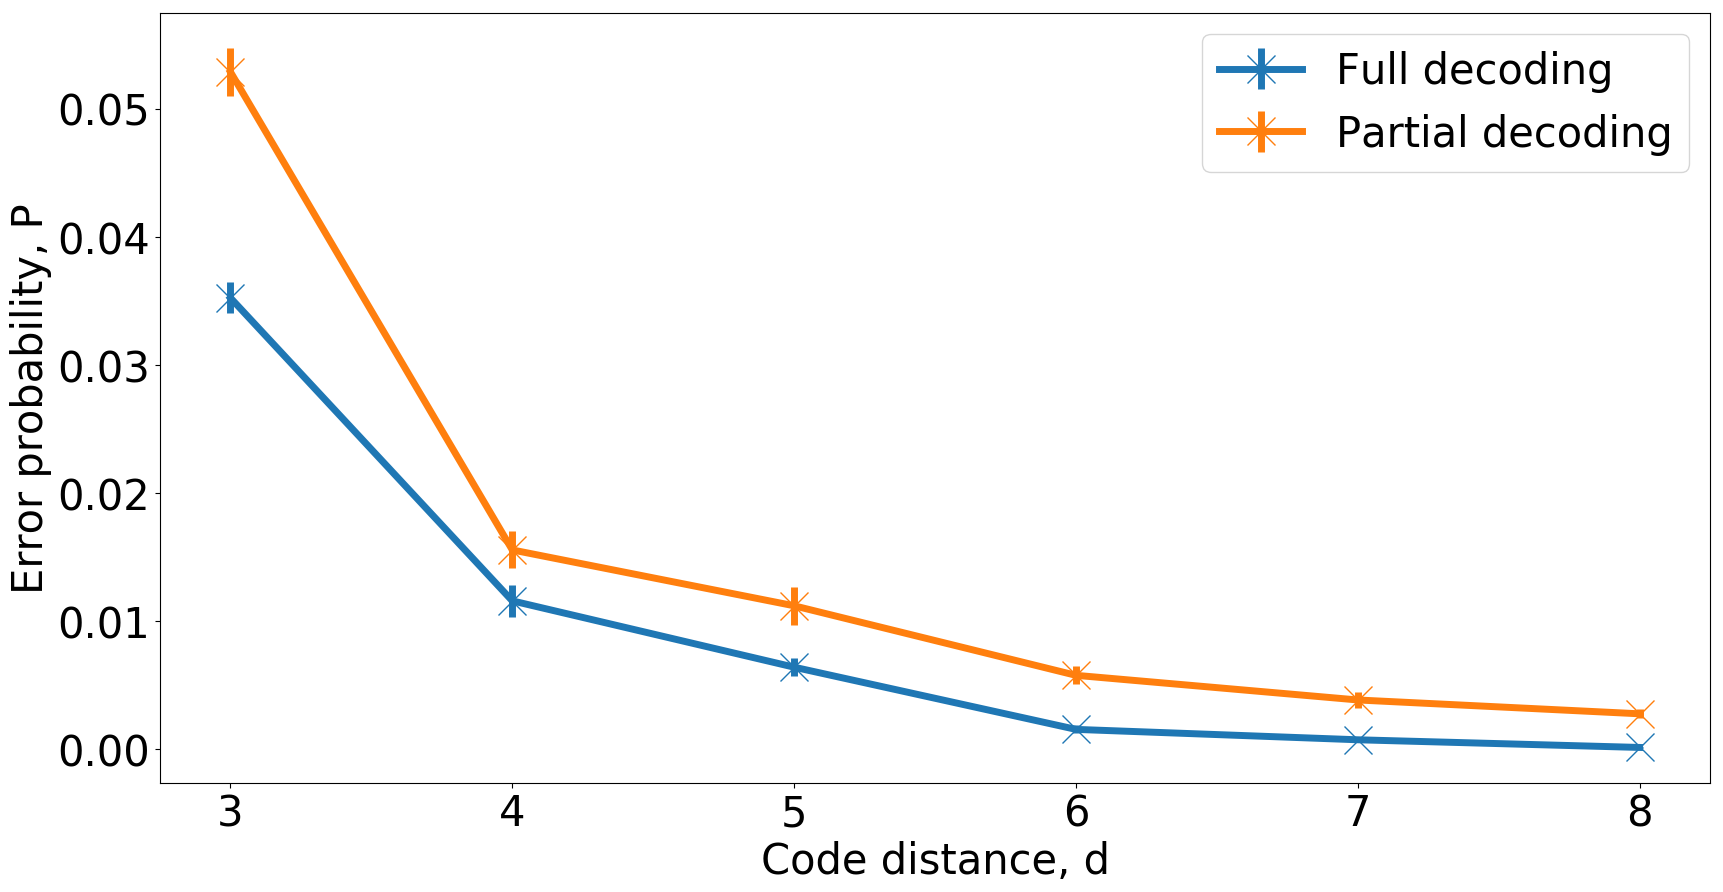

In [17]:
for encodedBit in range(2): # separate plots for each encoded bit
    X = range(3,maxSize+1)
    Y = []
    y = []
    for decoding in ['full','partial']:
        dec = (decoding=='partial') # this is treated as 0 if full and 1 if partial
        Y.append([codeResults[encodedBit][d-3][0][2*dec+0] for d in range(3,maxSize+1)])
        y.append([codeResults[encodedBit][d-3][0][2*dec+1] for d in range(3,maxSize+1)])
    MakeGraph(X,Y,y,['Code distance, d','Error probability, P'],
              labels=['Full decoding','Partial decoding'],legendPos='upper right')
     

The following graphs focus on the case of partial decoding. They look at the probabilities for different kinds of errors on the code qubits, as well as the way in in which the decoding is performed.

When doing this we will combine the data from all 10 runs, to get a single data set that is cleaner than all the others. This will mean a lack of error bars, but we know what kind of values these would give from previous plots.

In this analysis, we will use the fact that it is pretty much just the number of *0*s and *1*s in a result that is important, and not their placement. So we'll look at the probability for each number of *1*s.

We'll plot this in two ways for each code distance. First we'll plot the number probability for each number of errors. For example, *00000* would have no errors in the case that *0* was stored, but five if *1* was stored. We would expect to see the probability decrease with the number of errors for both stored *0* and stored *1*.

We will then plot the number of *1*s. For stored *0*, this corresponds to the number of errors, and so we would expect it to decrease. For stored *1* it is the opposite, since no *1*s is the case of maximum error. The probability should therefore increase for this data. There will therefore be a crossover point for the number of *1*s, which explictly tells us something about decoding. If the number of *1*s in a given result is below the crossover point, the most likely encoded value is *0*. Above the crossover point, the most likely value is *1*.



***Probability of errors on code qubits for d = 3***


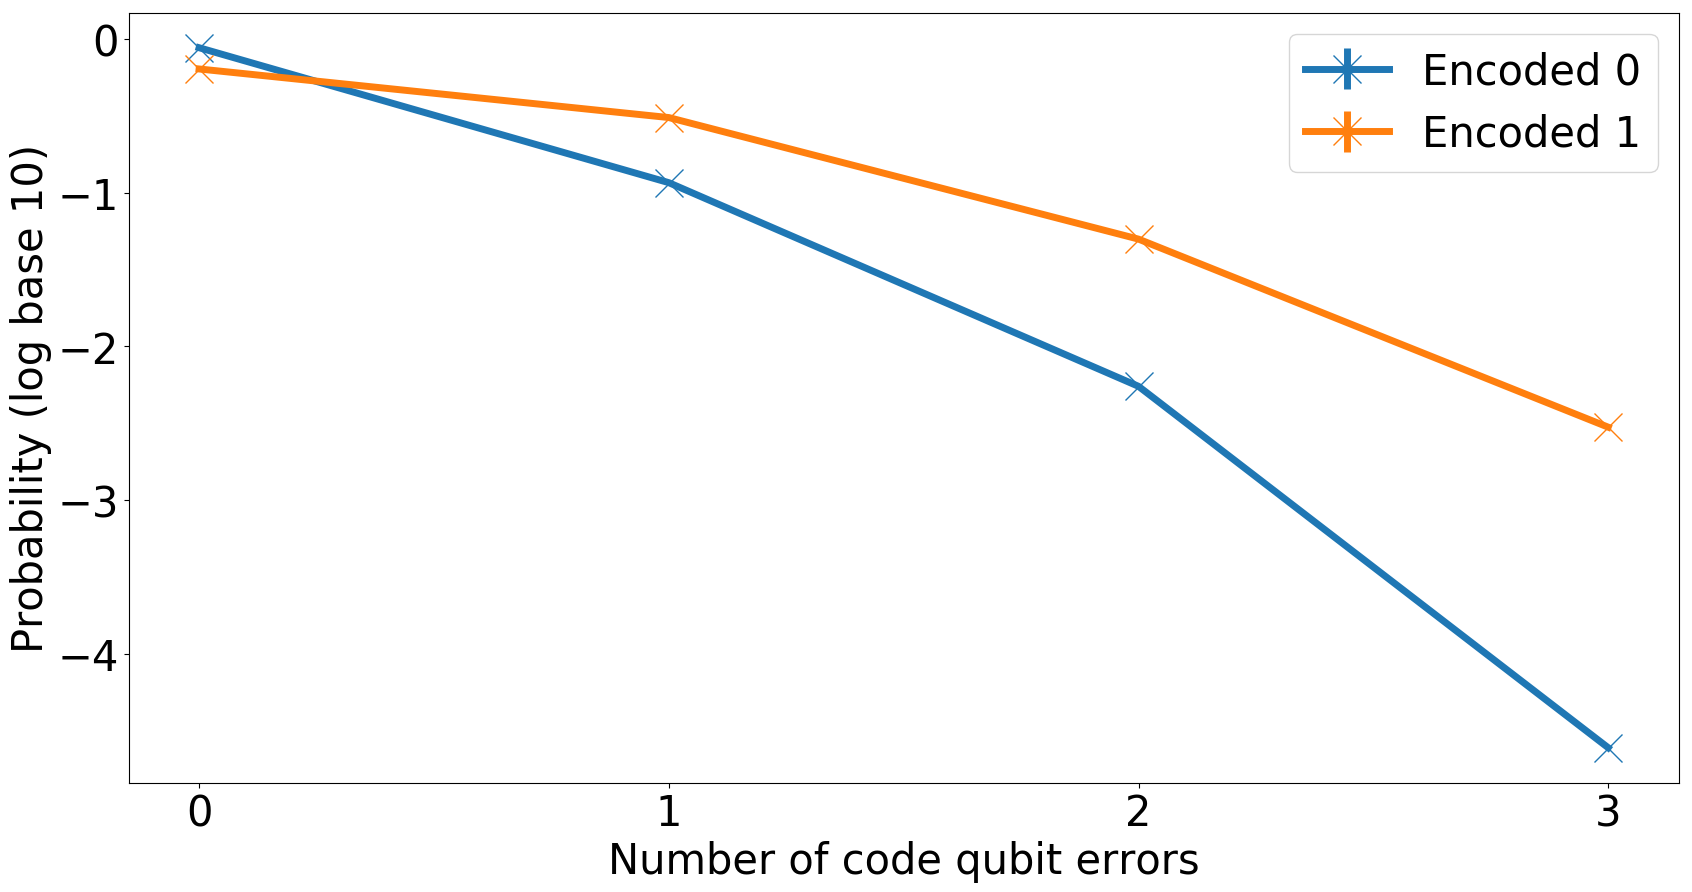



***Probability for number of 1s in code qubit result for d = 3***


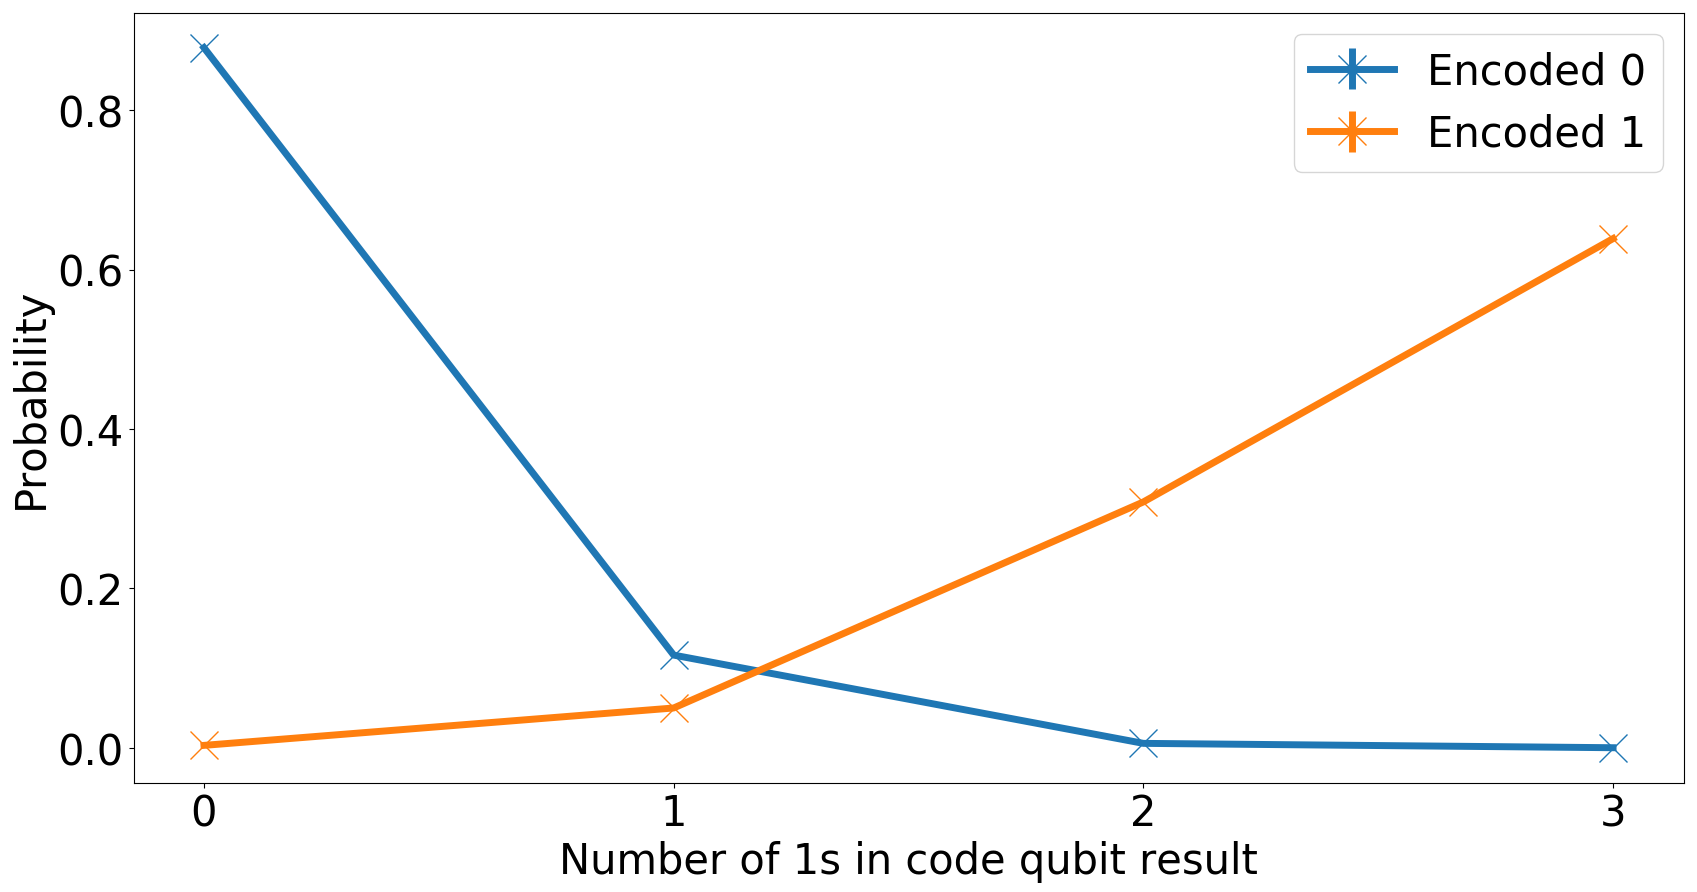



***Probability of errors on code qubits for d = 4***


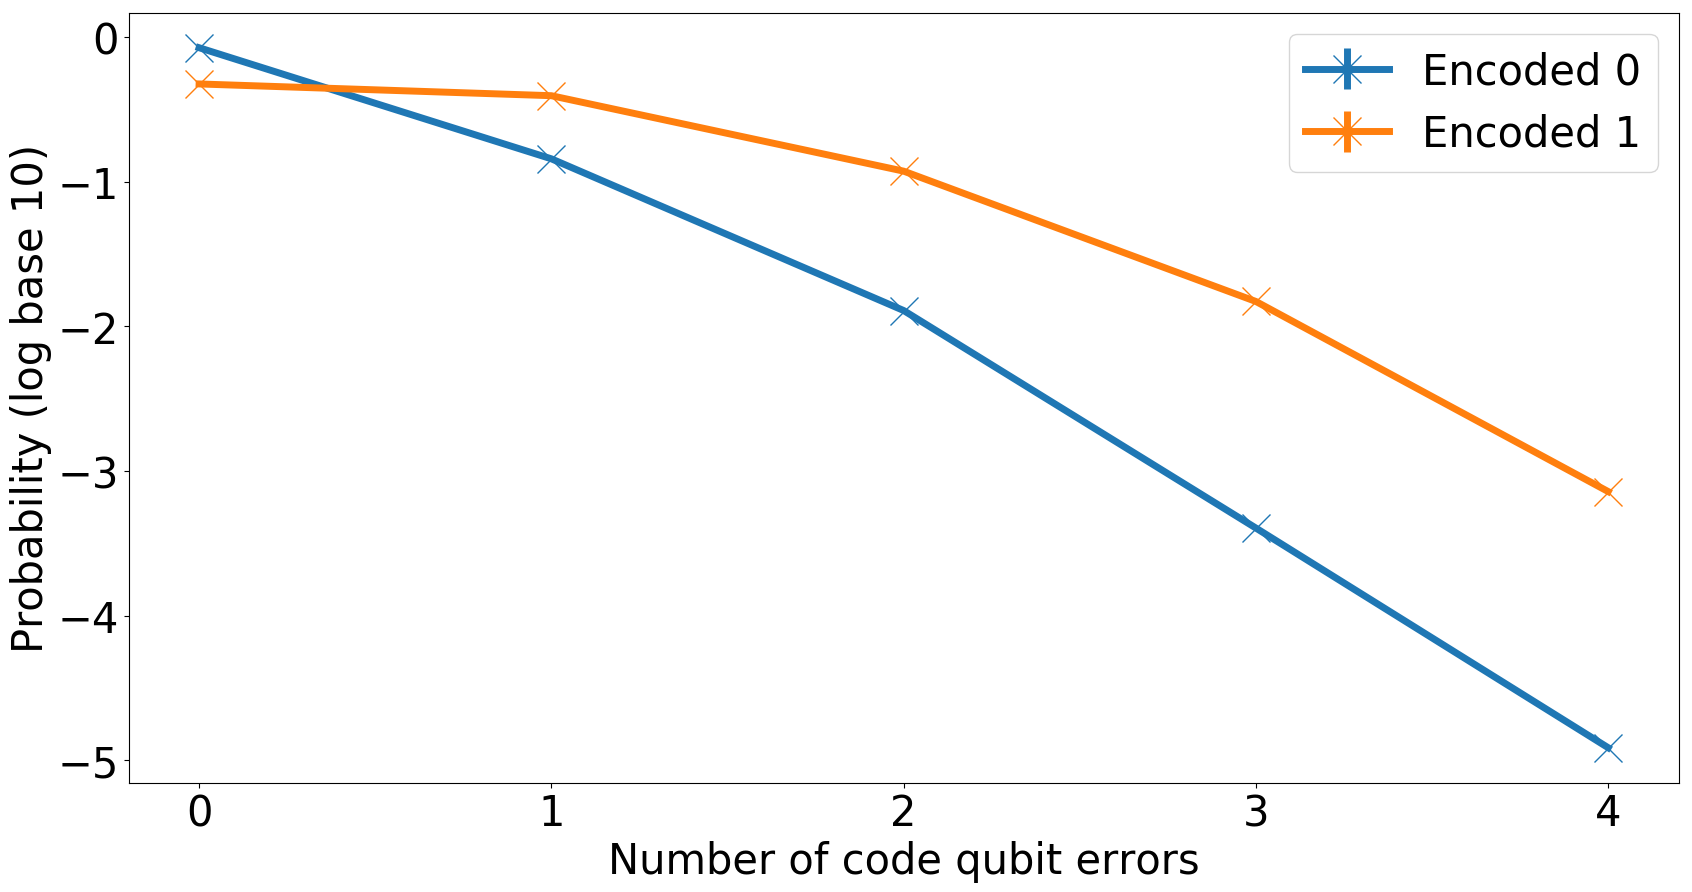



***Probability for number of 1s in code qubit result for d = 4***


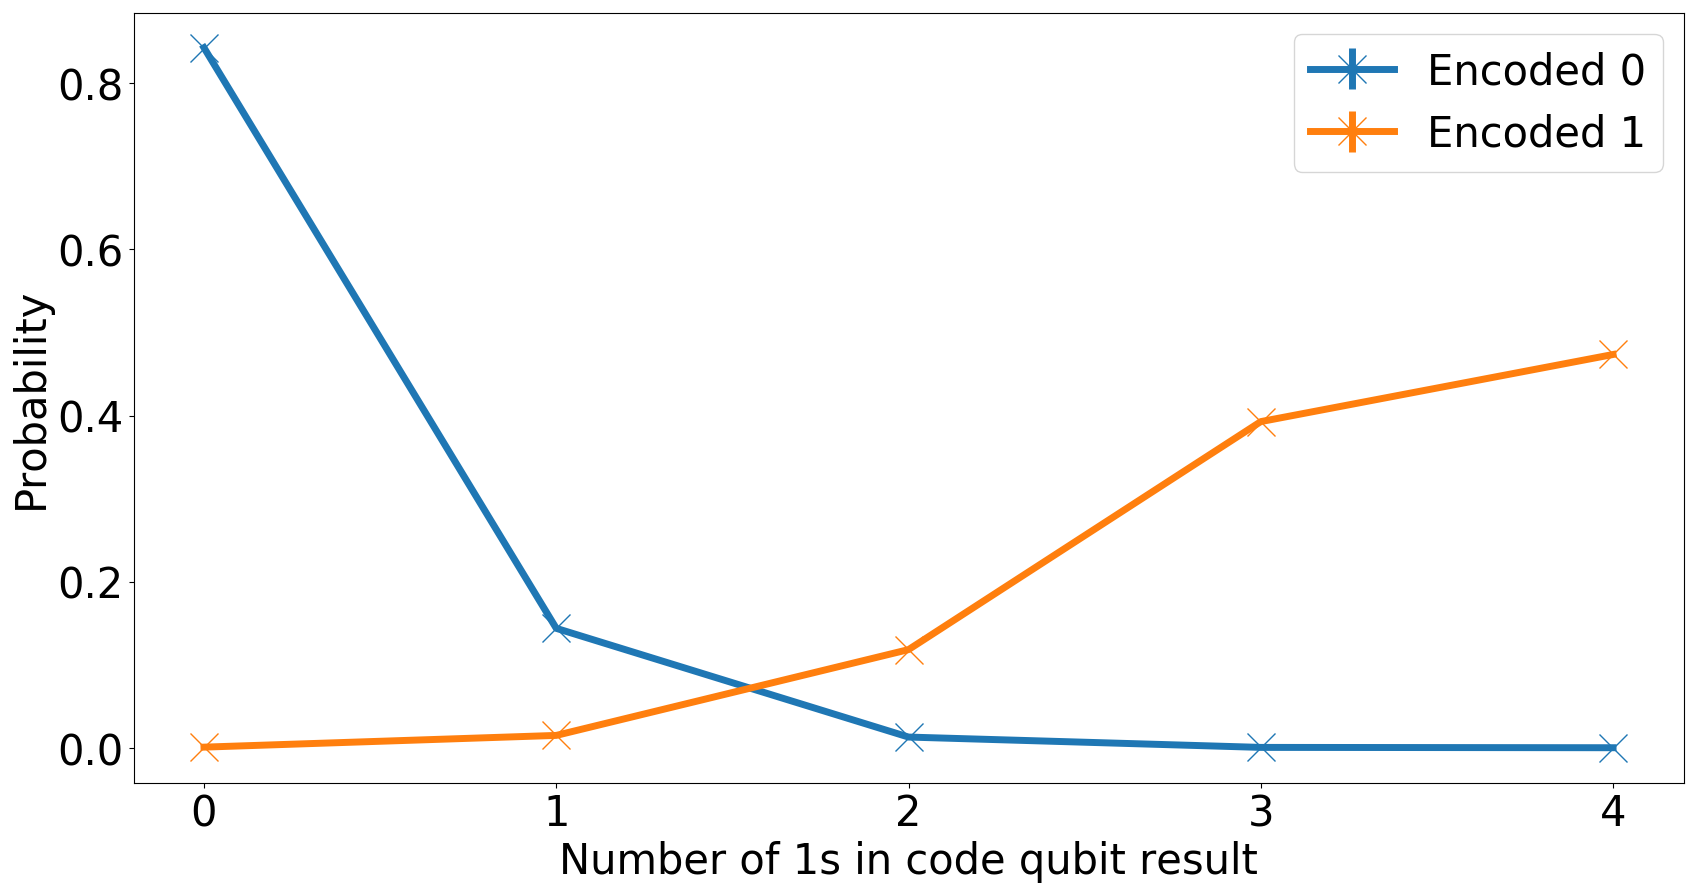



***Probability of errors on code qubits for d = 5***


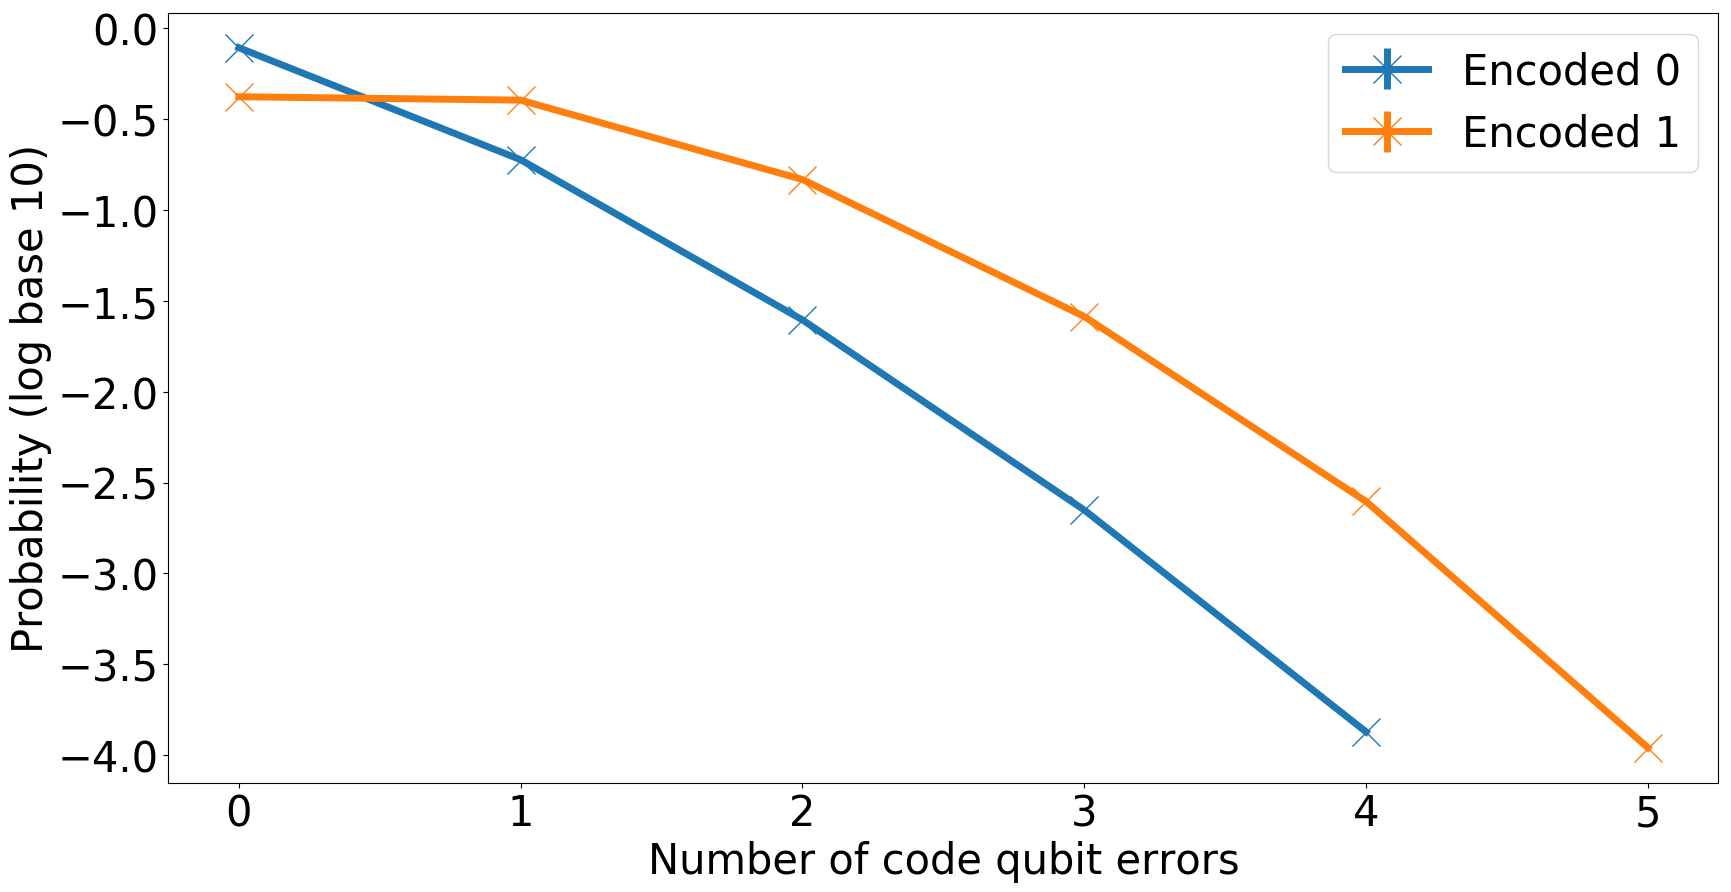



***Probability for number of 1s in code qubit result for d = 5***


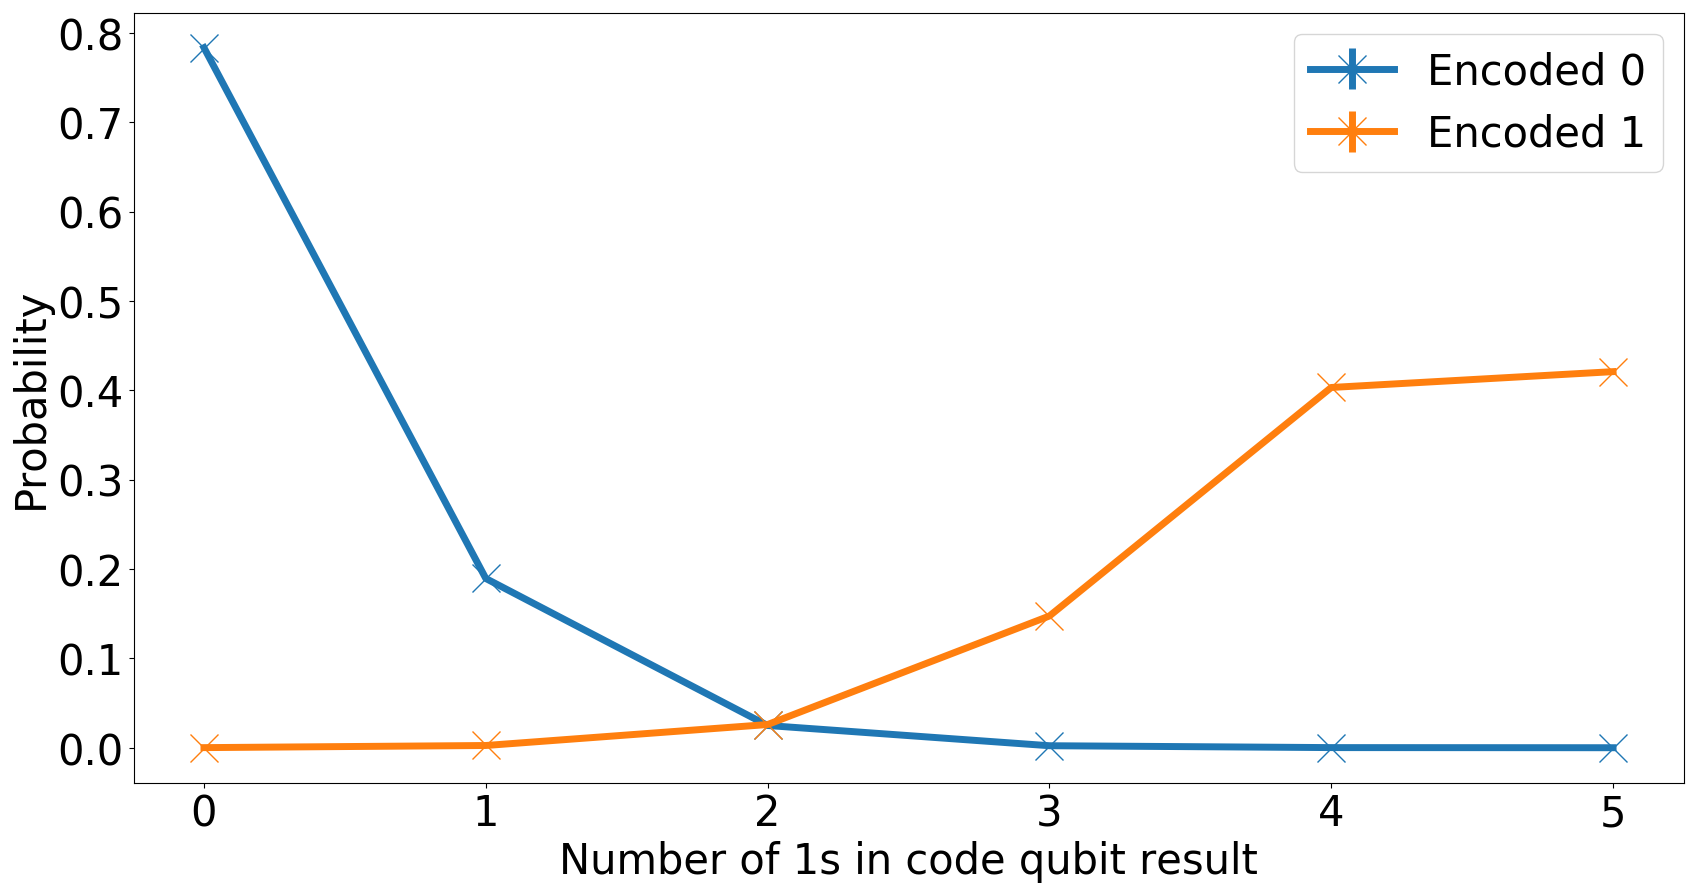



***Probability of errors on code qubits for d = 6***


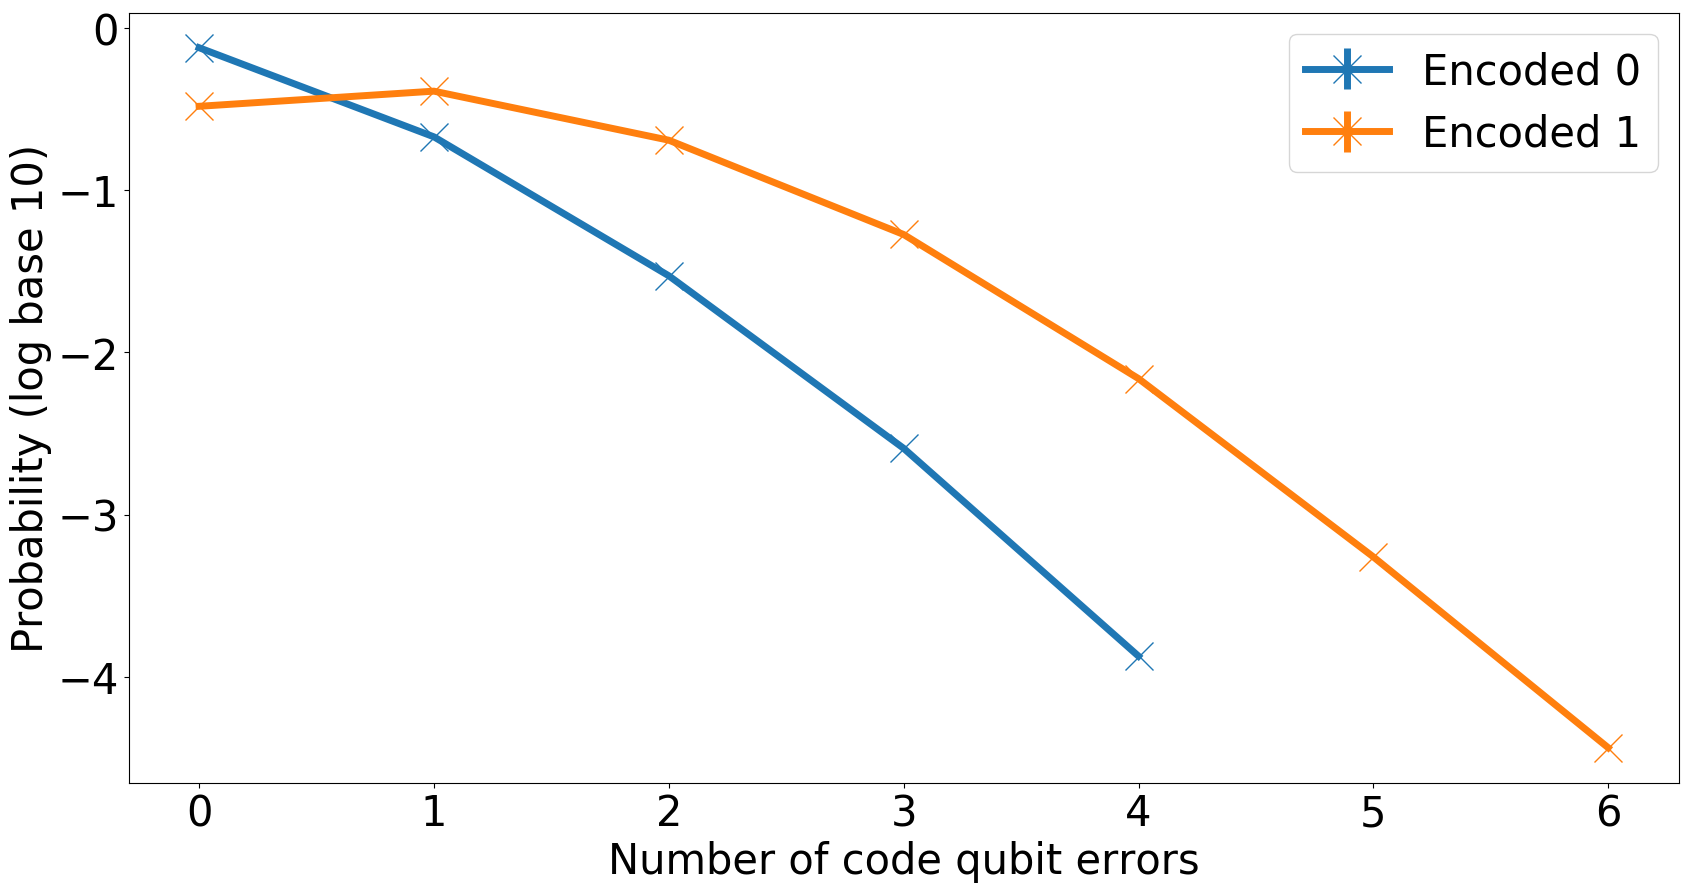



***Probability for number of 1s in code qubit result for d = 6***


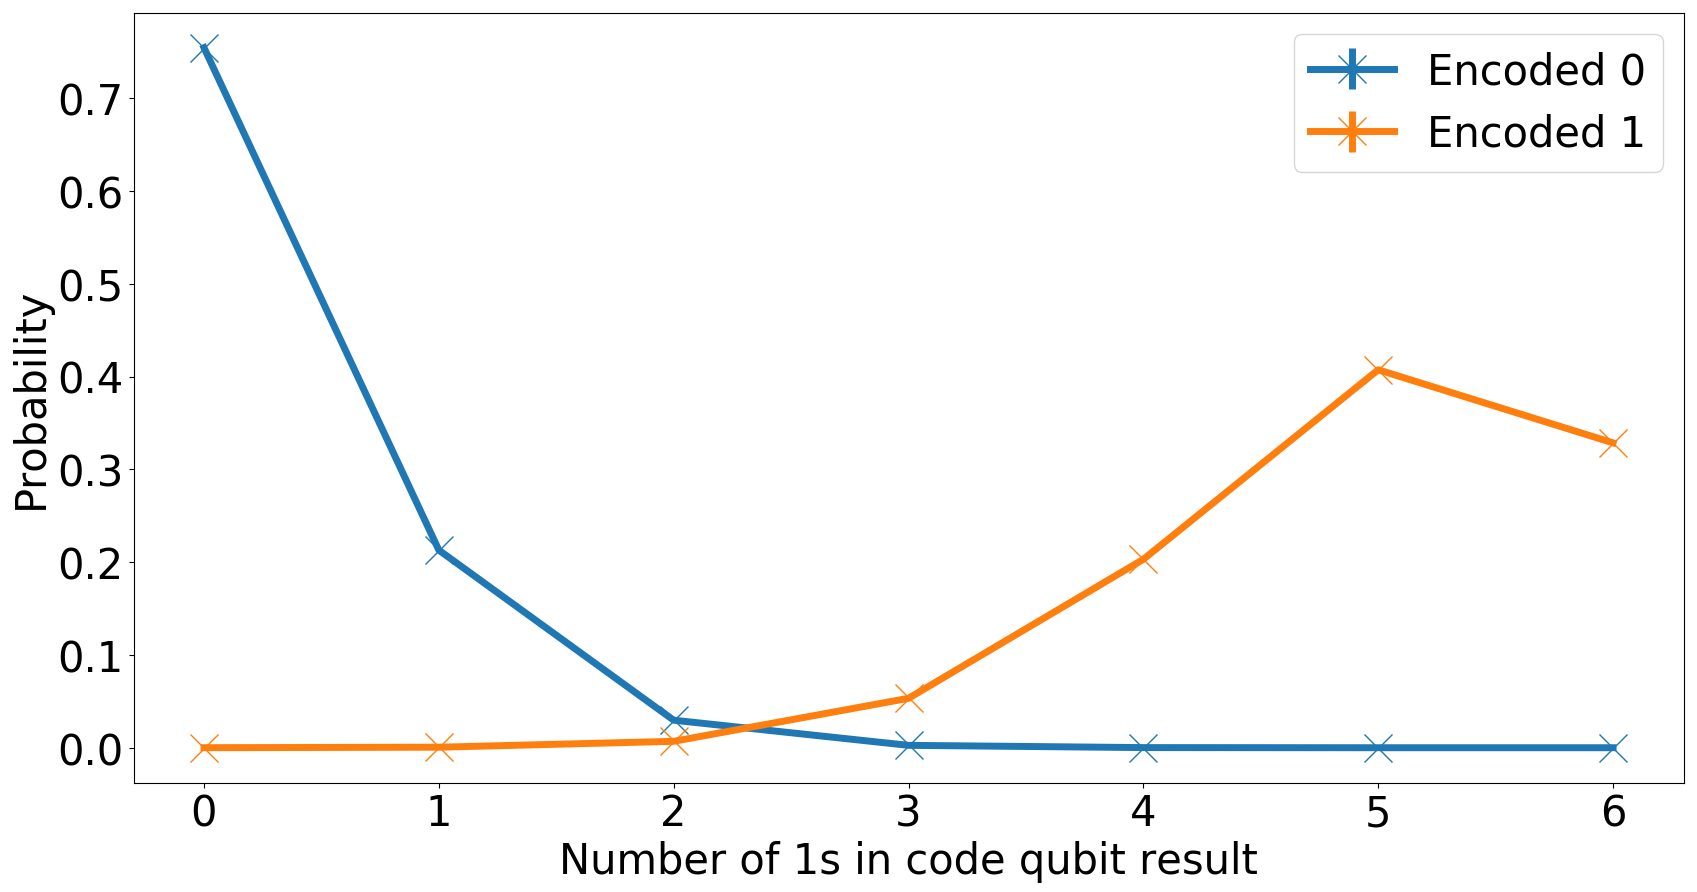



***Probability of errors on code qubits for d = 7***


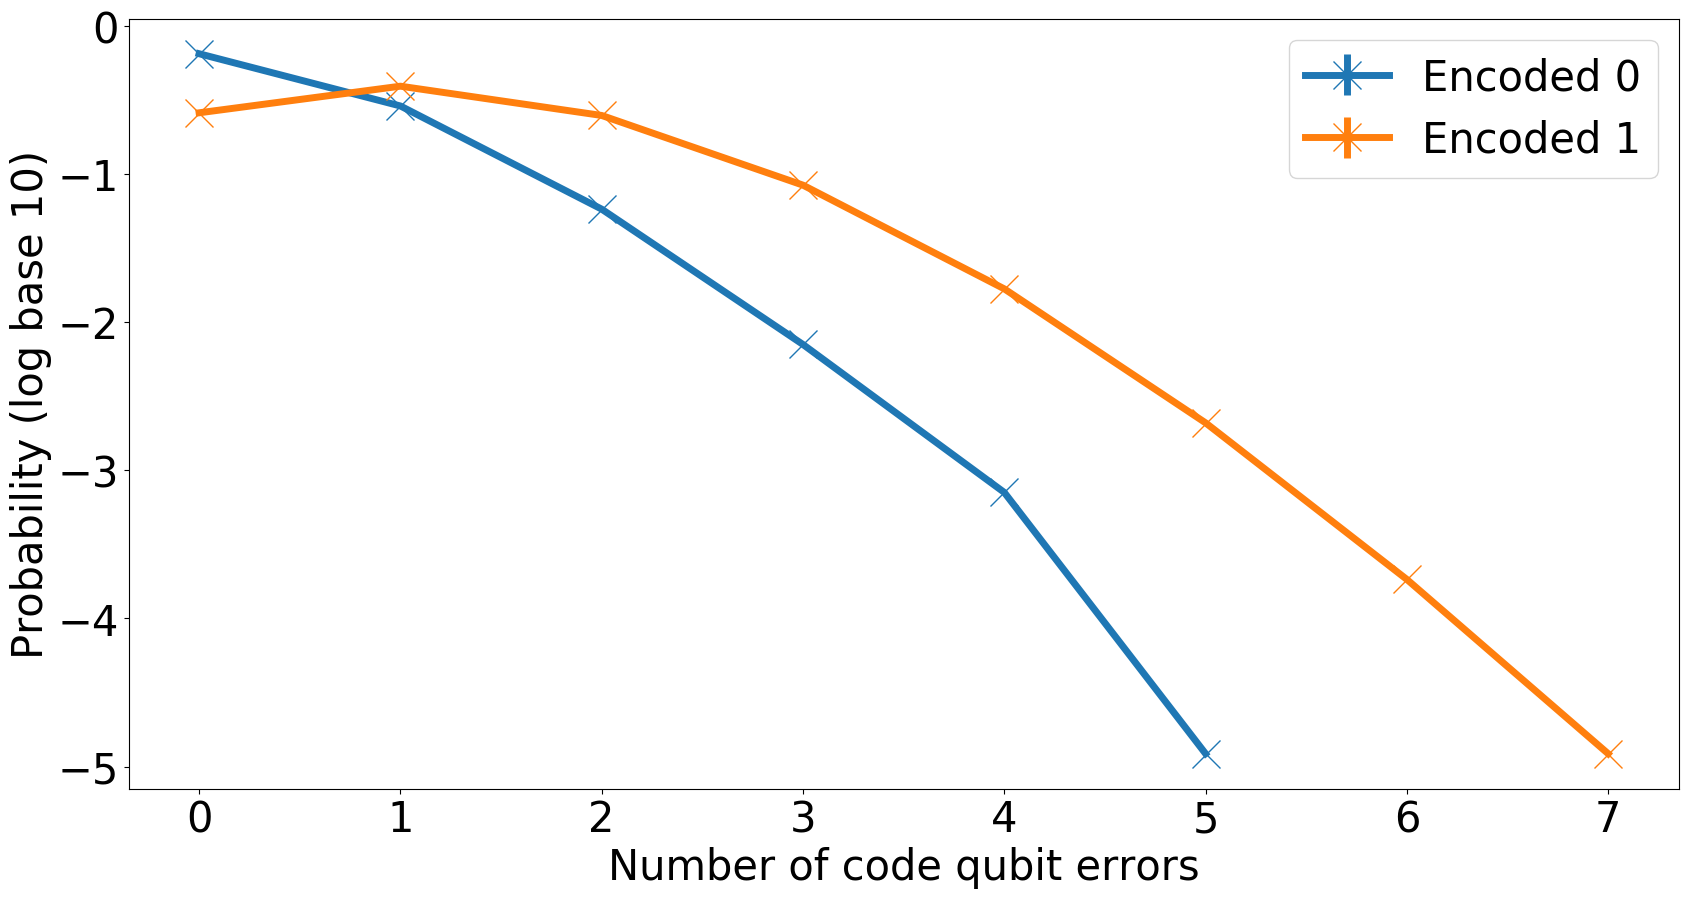



***Probability for number of 1s in code qubit result for d = 7***


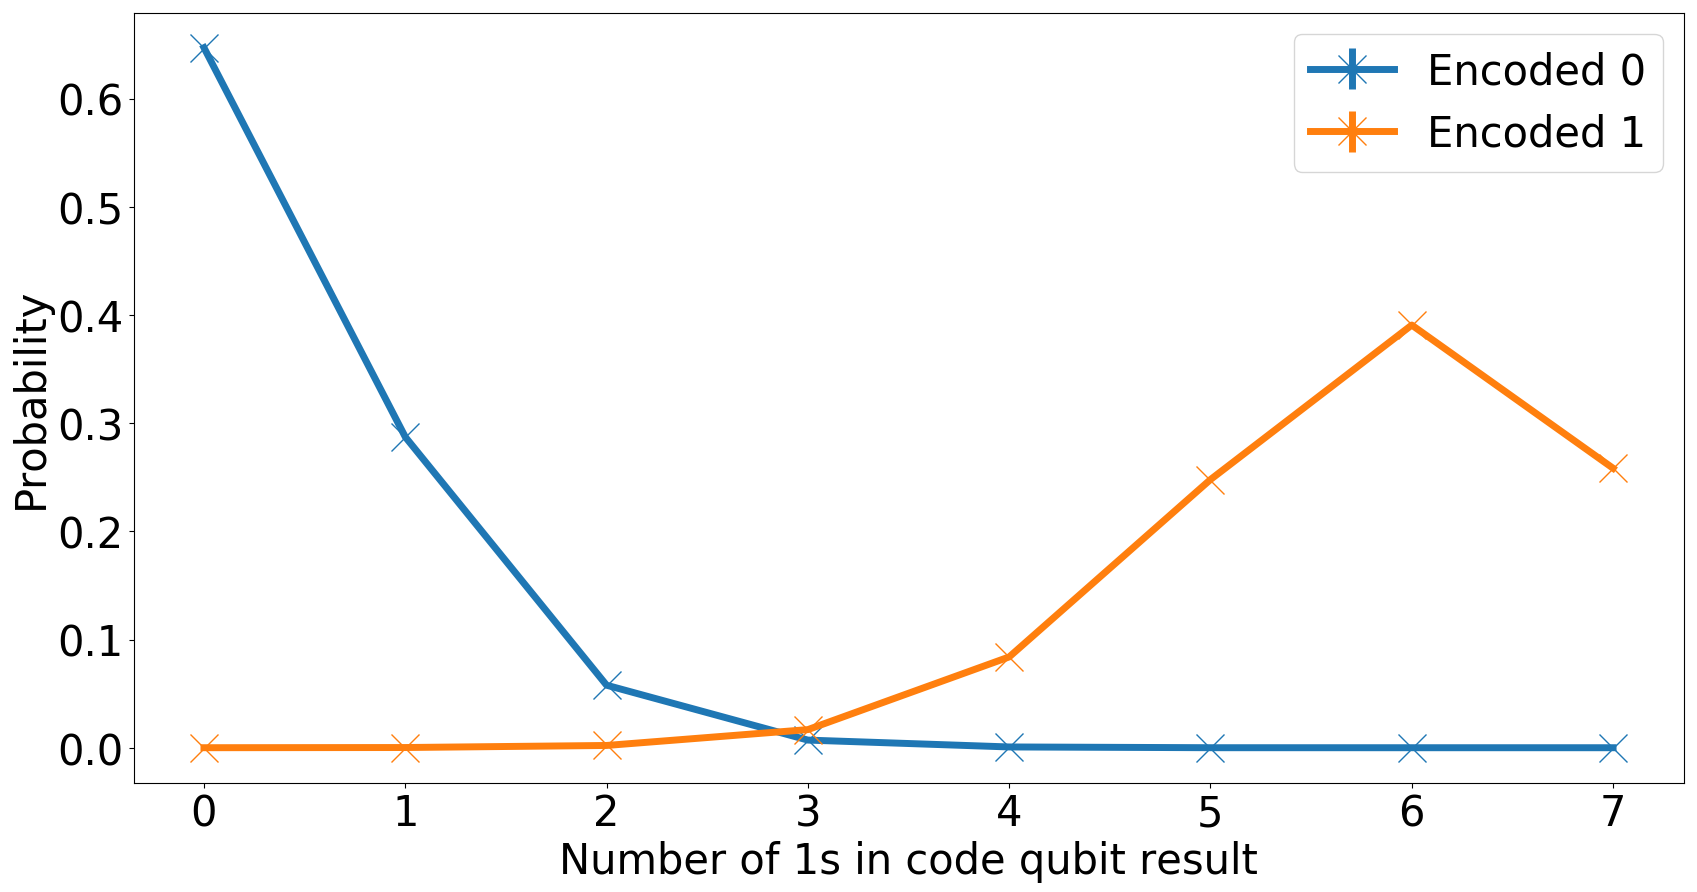



***Probability of errors on code qubits for d = 8***


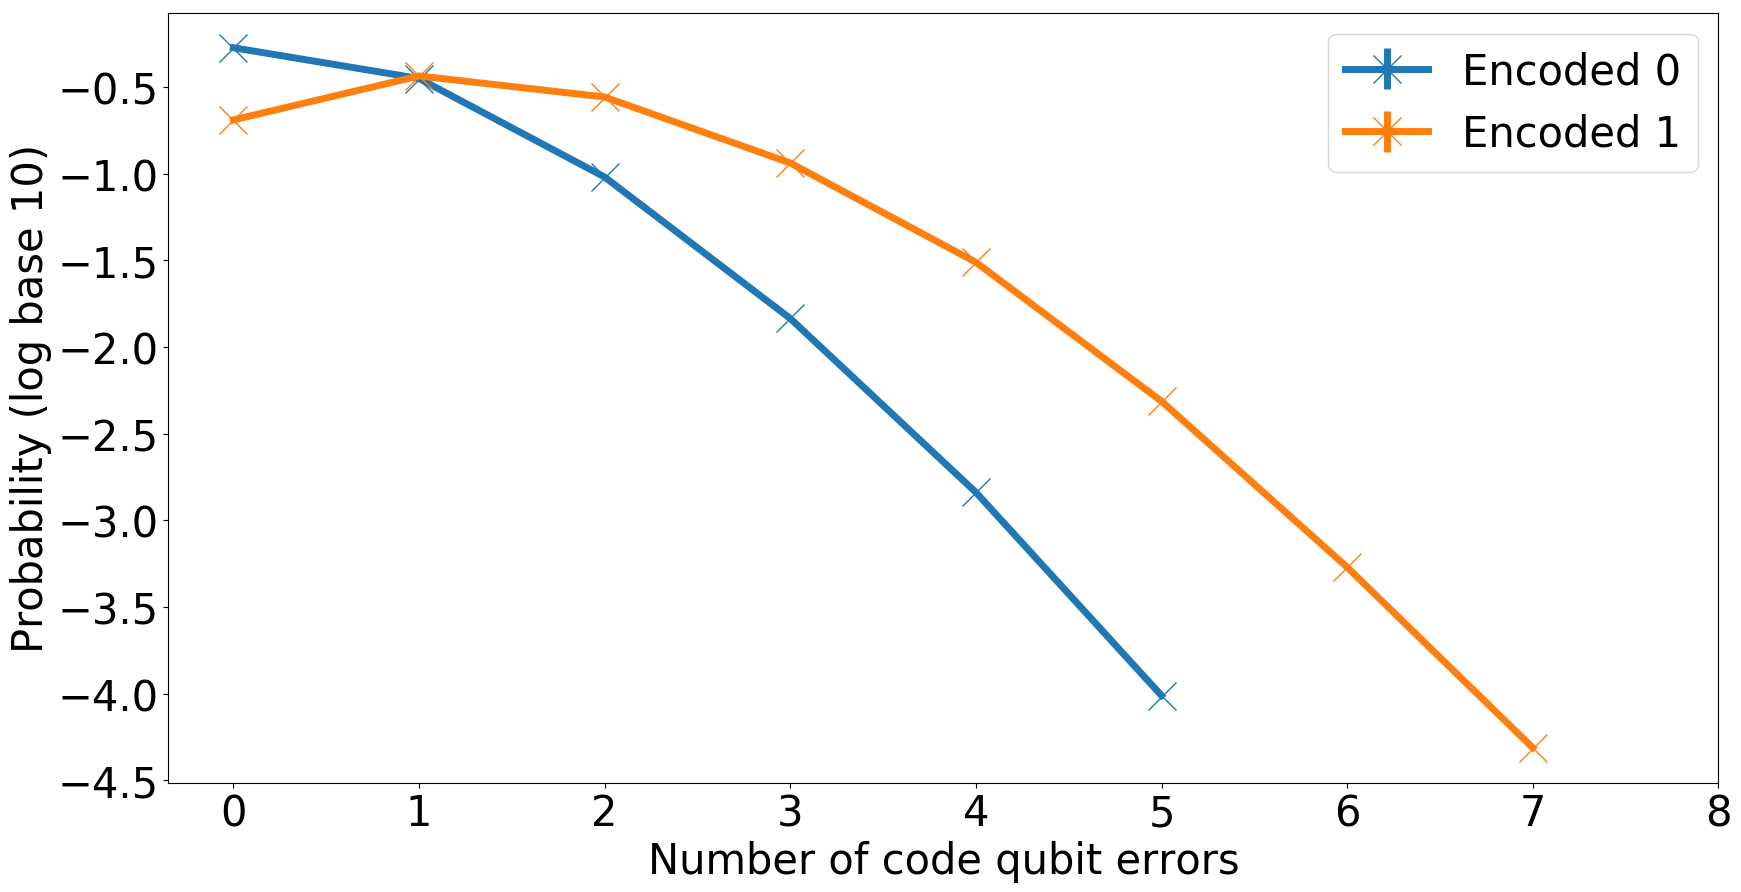



***Probability for number of 1s in code qubit result for d = 8***


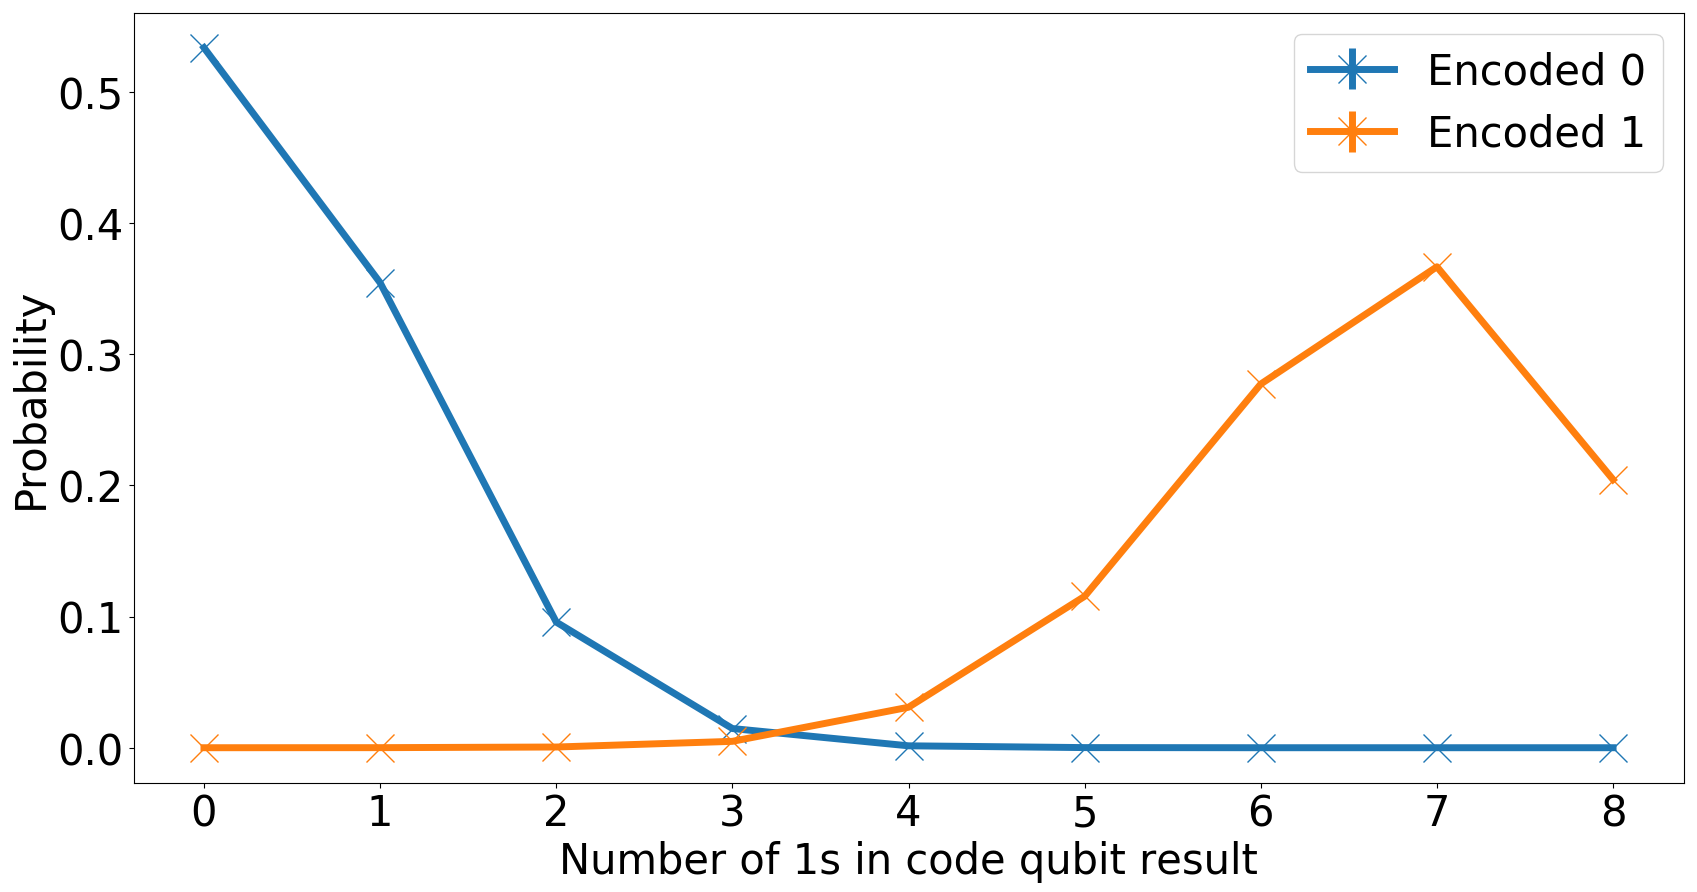

In [18]:
# for each code distance and each encoded bit value, we'll create a list of the probabilities for each possible number of errors
# list is initialized with zeros
errorNum = [[[0]*(d+1) for d in range(3,maxSize+1)] for _ in range(2)]

for d in range(3,maxSize+1):
        for bit in range(2):
            # for each code distance and each encoded bit value we look at all possible result strings
            for string in combinedResultsCode[bit][d-3]:
                # count the number of errors in each string
                num = 0
                for j in range(d):
                    num += ( int( string[j] , 2 ) + bit )%2
                # add prob to corresponding number of errors
                errorNum[bit][d-3][num] += combinedResultsCode[bit][d-3][string]
        

        # the we make a graph for each, and print a title
        X0 = copy.copy(errorNum[0][d-3]) 
        X1 = copy.copy(errorNum[1][d-3]) # the lists given to MakeGraph can get altered, so we don't put errorNum itself in
        print("\n\n***Probability of errors on code qubits for d = " + str(d) + "***")
        MakeGraph(range(d+1),[X0,X1],[[0]*(d+1)]*2,['Number of code qubit errors','Probability (log base 10)'],
                  labels=['Encoded 0','Encoded 1'],legendPos='upper right',log=True)

        # actually, we make two graphs. This one plots the number of 1s rather than errors, and so the plot for encoded 1 is inverted
        X0 = copy.copy(errorNum[0][d-3]) # X0 in this graph is as before
        X1 = copy.copy(errorNum[1][d-3])[::-1] # but X1 has its order inverted
        print("\n\n***Probability for number of 1s in code qubit result for d = " + str(d) + "***")
        MakeGraph(range(d+1),[X0,X1],[[0]*(d+1)]*2,['Number of 1s in code qubit result','Probability'],
                  labels=['Encoded 0','Encoded 1'],legendPos='upper right')    